<a href="https://colab.research.google.com/github/arife-16/ASD-project/blob/main/cv_baselines_across_sites_and_atlases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ASD Classification using Functional Connectivity: A Site Based Comparision

This notebook establishes baseline classification performance for Autism Spectrum Disorder (ASD) vs. Typically Developing (TD) individuals using resting-state fMRI data from the ABIDE PCP dataset.

## Core Objectives:
1.  Develop a pipeline that includes site harmonization using ComBat and regression of common confounds (age, sex, motion).
2.  Train and evaluate standard machine learning models (Logistic Regression, SVM) on functional connectivity data.
3.  Use both nested cross-validation and Leave-One-Site-Out (LOSO) cross-validation to ensure unbiased performance estimates and test for model generalizability across different acquisition sites.
4.  Compare the standard FC vector approach with a more advanced method using tangent space representation of connectivity matrices.

The analysis is performed across three common brain parcellation atlases: **AAL116, CC200, and CC400**.

# Nested CV Baselines — ComBat + Confounds

Runs Logistic Regression (and SVM variants) with **fold-safe ComBat** and **confound regression** across **AAL116/CC200/CC400**.

In [ ]:
PROJECT_ROOT = '/content/drive/MyDrive/ASD-project'

%cd $PROJECT_ROOT
%pip -q install -U --force-reinstall -r requirements.txt

/content/drive/MyDrive/ASD-project
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.9 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python <3.12,>=3.8; 1.10.0rc1 Requires-Python <3.12,>=3.8; 1.10.0rc2 Requires-Python <3.12,>=3.8; 1.10.1 Requires-Python <3.12,>=3.8; 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3

In [ ]:
%pip -q install "neuroHarmonize==2.4.5" "neuroCombat>=0.2.10"

  Preparing metadata (setup.py) ... done


In [ ]:
import os, json, numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedGroupKFold

from src.utils import set_global_seed, ensure_dir
from src.data import DataPaths, load_metadata, link_fc_paths, load_upper_triangle_from_npy
from src.harmonize import combat_fit, combat_apply
from src.confounds import ConfoundRegressor
from src.models_ml import MLConfig, build_pipeline
from src.metrics import compute_metrics, bootstrap_ci

set_global_seed(1337)

In [ ]:
import os
import numpy as np, pandas as pd

PHENOTYPE_CSV = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'
FC_BASE_DIR   = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset'

atlas_to_subdir = {
    "AAL116": "fc_matrices_aal",
    "CC200":  "rois_cc200_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc200",
    "CC400":  "rois_cc400_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc400",
}

By binarizing the phenotypic columns, we will use them in the classification models.

* The diagnostic group (`DX_GROUP`) is converted into a binary label `y` (1 for ASD, 0 for TD).
* The acquisition site (`SITE_ID`) is extracted to be used as the `group` variable for grouped cross-validation, preventing data leakage.
* Key confounds—**Age**, **Sex**, and **Mean Framewise Displacement (Mean FD)**—are selected and prepared for later regression. Missing values are imputed with the median.

In [ ]:
# the helpers
def _upper_triangle(mat: np.ndarray) -> np.ndarray:
    mat = 0.5 * (mat + mat.T)
    np.fill_diagonal(mat, 0.0)
    iu = np.triu_indices_from(mat, k=1)
    return mat[iu]

def _fisher_z(r: np.ndarray) -> np.ndarray:
    r = np.clip(r, -0.999999, 0.999999)
    return 0.5 * np.log((1.0 + r) / (1.0 - r))

def _corr_from_timeseries(ts: np.ndarray) -> np.ndarray:
    """
    Pearson correlation from time-series with potential zero-variance ROIs.
    ts: shape (T, R)
    """
    if ts.ndim == 1:
        ts = ts[:, None]
    # Standardize with protection against zero std
    mean = ts.mean(axis=0, keepdims=True)
    std  = ts.std(axis=0, ddof=1, keepdims=True)
    safe_std = np.where(std == 0, 1.0, std)
    z = (ts - mean) / safe_std  # columns (ROIs) standardized; zero-variance columns become zeros
    # sample correlation via normalized covariance
    T = z.shape[0]
    corr = (z.T @ z) / max(T - 1, 1)
    # zero rows/cols that correspond to zero-variance ROIs (std==0)
    bad = (std.flatten() == 0)
    if bad.any():
        corr[:, bad] = 0.0
        corr[bad, :] = 0.0
    np.fill_diagonal(corr, 1.0)
    return corr

def _load_fc_vector_from_file(path: str, atlas_key: str) -> np.ndarray:
    """AAL116: path -> .npy connectivity matrix
       CC200/CC400: path -> .1D ROI time series"""
    if atlas_key == "AAL116":
        mat = np.load(path)
        return _upper_triangle(mat)

    ts = np.loadtxt(path)
    corr = _corr_from_timeseries(ts)
    corr_z = _fisher_z(corr)
    return _upper_triangle(corr_z)

def _normalize_pheno_columns(df: pd.DataFrame) -> pd.DataFrame:

    df = df.rename(columns={c: c.upper() for c in df.columns})

    if "MEAN_FD" not in df.columns:
        for cand in ["FUNC_MEAN_FD", "FUNC_MEANFD", "MEANFD"]:
            if cand in df.columns:
                df["MEAN_FD"] = pd.to_numeric(df[cand], errors="coerce")
                break
        if "MEAN_FD" not in df.columns:
            df["MEAN_FD"] = np.nan

    if "DX_GROUP" in df.columns:
        df["DX_GROUP"] = df["DX_GROUP"].astype(str).str.strip()
        df["LABEL"] = df["DX_GROUP"].map({"1": "ASD", "2": "TD", "ASD": "ASD", "TD": "TD"})

    if "SEX" in df.columns:
        df["SEX"] = df["SEX"].astype(str).str.upper().str.strip()
        df["SEX_NUM"] = df["SEX"].map({"M": 1, "F": 0, "1": 1, "2": 0}).fillna(0).astype(int)
    else:
        df["SEX_NUM"] = 0

    df["FILE_ID"] = df["FILE_ID"].astype(str).str.strip()
    return df

* To reduce redundancy and dimensionality, only the values from the **upper triangle** of the connectivity matrix are extracted.
* For the CC200/CC400 atlases, a **Fisher's Z-transformation** ($z = 0.5 \cdot \ln(\frac{1+r}{1-r})$) is applied to the correlation values. This stabilizes the variance and makes the data distribution more Gaussian.

In [ ]:
def prepare_dataset(atlas: str):
    df = pd.read_csv(PHENOTYPE_CSV)
    df = _normalize_pheno_columns(df)

    subdir = atlas_to_subdir[atlas]
    base_dir = os.path.join(FC_BASE_DIR, subdir)

    if atlas == "AAL116":
        df["FC_PATH"] = df["FILE_ID"].apply(lambda fid: os.path.join(base_dir, f"{fid}.npy"))
    elif atlas == "CC200":
        df["FC_PATH"] = df["FILE_ID"].apply(lambda fid: os.path.join(base_dir, f"{fid}_rois_cc200.1D"))
    elif atlas == "CC400":
        df["FC_PATH"] = df["FILE_ID"].apply(lambda fid: os.path.join(base_dir, f"{fid}_rois_cc400.1D"))
    else:
        raise ValueError("Unknown atlas key")

    exists = df["FC_PATH"].map(os.path.exists)
    missing = (~exists).sum()
    if missing > 0:
        print(f"[{atlas}] Warning: {missing} subjects missing files under {base_dir}. Showing 5 examples:")
        print(df.loc[~exists, ["FILE_ID", "FC_PATH"]].head())

    df = df.loc[exists].reset_index(drop=True)
    if len(df) == 0:
        raise FileNotFoundError(f"No files found for {atlas} in {base_dir}.")

    # Build upper-triangle vectors, labels, groups, confounds
    X = np.vstack([_load_fc_vector_from_file(p, atlas) for p in df["FC_PATH"]])
    y = (df["LABEL"].values == "ASD").astype(int)
    groups = df["SITE_ID"].astype(str).values

    conf_df = df[["AGE_AT_SCAN", "SEX_NUM", "MEAN_FD"]].apply(pd.to_numeric, errors="coerce")
    conf_df = conf_df.fillna(conf_df.median(numeric_only=True))
    confounds = conf_df.values

    return X, y, groups, confounds, df

counts: **N=884 (ASD=408, TD=476)**

with **76636** features

In [ ]:
for atlas in ["CC400"]: #test the function
    try:
        X, y, g, C, meta = prepare_dataset(atlas)
        print(atlas, "X:", X.shape, "labels:", np.bincount(y))
        print("  sample path:", meta["FC_PATH"].iloc[0])
    except Exception as e:
        print(atlas, "skipped:", repr(e))

[CC400] Warning: 228 subjects missing files under /content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/rois_cc400_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc400. Showing 5 examples:
         FILE_ID                                            FC_PATH
0    no_filename  /content/drive/MyDrive/ASD-project/data/ABIDE_...
1   Pitt_0050003  /content/drive/MyDrive/ASD-project/data/ABIDE_...
11  Pitt_0050013  /content/drive/MyDrive/ASD-project/data/ABIDE_...
15  Pitt_0050017  /content/drive/MyDrive/ASD-project/data/ABIDE_...
16  Pitt_0050019  /content/drive/MyDrive/ASD-project/data/ABIDE_...
CC400 X: (884, 76636) labels: [476 408]
  sample path: /content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/rois_cc400_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc400/Pitt_0050004_rois_cc400.1D


In [ ]:
from src.harmonize import combat_fit, combat_apply
from src.confounds import ConfoundRegressor
import pandas as pd, numpy as np

def fold_safe_transform(X_tr, X_te, groups_tr, groups_te, conf_tr, conf_te, use_combat=True):
    unseen = np.setdiff1d(np.unique(groups_te), np.unique(groups_tr))
    do_combat = use_combat and (len(unseen) == 0)

    # 1) Site harmonization (ComBat) — only if all test sites were seen in training
    if do_combat:
        try:
            cov_tr = pd.DataFrame(conf_tr, columns=["AGE","SEX","FD"])
            cov_te = pd.DataFrame(conf_te, columns=["AGE","SEX","FD"])
            model  = combat_fit(X_tr, pd.Series(groups_tr), cov_tr)
            Xtr_h  = combat_apply(model, X_tr, pd.Series(groups_tr), cov_tr)
            Xte_h  = combat_apply(model, X_te, pd.Series(groups_te),  cov_te)
        except Exception as e:
            print(f"[ComBat disabled this fold] {e}")
            Xtr_h, Xte_h = X_tr, X_te
    else:
        if use_combat and len(unseen) > 0:
            print(f"[ComBat off] test has unseen site(s): {list(unseen)}")
        Xtr_h, Xte_h = X_tr, X_te

    # 2) Confound regression
    reg = ConfoundRegressor().fit(Xtr_h, conf_tr)
    Xtr_r = reg.transform(Xtr_h, conf_tr)
    Xte_r = reg.transform(Xte_h, conf_te)
    return Xtr_r, Xte_r

Multi-site datasets like ABIDE are often affected by scanner-specific "batch effects" that can confound classification. To address this, we define a `fold_safe_transform` function that applies harmonization and confound removal steps **only using information from the training set** to avoid data leakage into the test set.

1.  **Fold-Safe ComBat Harmonization**:
    * ComBat is a technique for harmonizing data by removing site-specific batch effects.
    * It is applied in a "fold-safe" manner: the ComBat model is fitted *only* on the training data (`X_tr`, `groups_tr`) for each fold of the cross-validation.
    * This trained model is then used to transform both the training data (`X_tr`) and the test data (`X_te`).
    * **Important Note**: ComBat cannot be applied to sites that were not seen during training. Therefore, it is automatically disabled during Leave-One-Site-Out (LOSO) validation, as the held-out test site is always unseen.

2.  **Confound Regression**:
    * After harmonization, a `ConfoundRegressor` is used to remove the linear effects of age, sex, and mean framewise displacement.
    * Similar to ComBat, the regressor is fitted *only* on the (harmonized) training data and then applied to transform both the train and test sets for that fold.

In [ ]:
import numpy as np, os, json
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedGroupKFold
from src.models_ml import MLConfig, build_pipeline
from src.metrics import compute_metrics, bootstrap_ci
from src.utils import ensure_dir

def run_nested_cv(atlas: str, model_name='lr', C_list=(0.0001,0.001,0.1,0.3,1.0,3.0,10.0), seed_outer=1337, seed_inner=2027, use_combat=True): # C list was build upon our previous experiments.
    X, y, groups, confounds, meta = prepare_dataset(atlas)
    outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed_outer)
    fold_results, y_all, p_all = [], [], []

    for fold, (tr_idx, te_idx) in enumerate(outer.split(X, y, groups=groups), 1):
        X_tr, X_te = X[tr_idx], X[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]
        g_tr, g_te = groups[tr_idx], groups[te_idx]
        c_tr, c_te = confounds[tr_idx], confounds[te_idx]

        inner = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=seed_inner)
        best_auc, best_C = -np.inf, None
        for C in C_list:
            aucs = []
            for itr, ival in inner.split(X_tr, y_tr, groups=g_tr):
                Xtr_i, Xval_i = X_tr[itr], X_tr[ival]
                ytr_i, yval_i = y_tr[itr], y_tr[ival]
                gtr_i, gval_i = g_tr[itr], g_tr[ival]
                ctr_i, cval_i = c_tr[itr], c_tr[ival]

                Xtr_t, Xval_t = fold_safe_transform(Xtr_i, Xval_i, gtr_i, gval_i, ctr_i, cval_i, use_combat=use_combat)
                pipe = build_pipeline(MLConfig(model=model_name, C=C))
                pipe.fit(Xtr_t, ytr_i)
                prob = pipe.predict_proba(Xval_t)[:,1]
                aucs.append(roc_auc_score(yval_i, prob))
            mean_auc = float(np.mean(aucs))
            if mean_auc > best_auc:
                best_auc, best_C = mean_auc, C

        Xtr_t, Xte_t = fold_safe_transform(X_tr, X_te, g_tr, g_te, c_tr, c_te, use_combat=use_combat)
        pipe = build_pipeline(MLConfig(model=model_name, C=best_C))
        pipe.fit(Xtr_t, y_tr)
        prob_te = pipe.predict_proba(Xte_t)[:,1]
        pred_te = (prob_te >= 0.5).astype(int)

        m = compute_metrics(y_te, prob_te, pred_te)
        m.update({"best_C": best_C, "fold": fold})
        fold_results.append(m)

        y_all.append(y_te); p_all.append(prob_te)
        print(f"[{atlas}] Fold {fold}: AUC={m['roc_auc']:.3f}, PR-AUC={m['pr_auc']:.3f}, Acc={m['accuracy']:.3f}, F1={m['f1']:.3f} (C={best_C})")

    y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
    auc_ci = bootstrap_ci(y_all, p_all, lambda yt, yp: roc_auc_score(yt, yp))
    pr_ci  = bootstrap_ci(y_all, p_all, lambda yt, yp: average_precision_score(yt, yp))
    return {
        "atlas": atlas, "model": model_name, "folds": fold_results,
        "mean": {k: float(np.mean([fr[k] for fr in fold_results])) for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "std":  {k: float(np.std([fr[k] for fr in fold_results]))  for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "bootstrap_ci": {"roc_auc": auc_ci, "pr_auc": pr_ci},
        "n_subjects": int(len(y))
    }


1.  **Nested Cross-Validation (`run_nested_cv`)**:
    * This method provides an unbiased estimate of the generalization error of the *entire modeling pipeline*, including hyperparameter tuning.
    * **Outer Loop (5-fold `StratifiedGroupKFold`)**: Splits the data into 5 folds for training and testing. Crucially, it uses `SITE_ID` as the grouping variable to ensure that subjects from the same site are kept together in either the training or test set, preventing the model from learning site-specific patterns that don't generalize.
    * **Inner Loop (3-fold `StratifiedGroupKFold`)**: Within each outer training fold, an inner CV loop is performed to find the best hyperparameter (e.g., the regularization strength `C` for LR/SVM) without touching the outer test set. The hyperparameter that yields the best average AUC in the inner loop is chosen.
    * **Final Evaluation**: The best hyperparameter from the inner loop is used to retrain the model on the *entire* outer training fold, and this final model is evaluated once on the outer test fold.

In [ ]:
def run_nested_models(atlas, models=("lr","svm_lin","svm_rbf")):
    out = {}
    for m in models:
        out[m] = run_nested_cv(atlas, model_name=m, use_combat=False)  # <- keep OFF for site-aware CV
    return out

cc400_models_nocom = run_nested_models("CC400", models=("lr","svm_lin","svm_rbf"))

from src.utils import ensure_dir
import os, json
ensure_dir(os.path.join(PROJECT_ROOT, "outputs"))
with open(os.path.join(PROJECT_ROOT, "outputs", "cc400_nested_lr_svm_noCombat.json"), "w") as f:
    json.dump(cc400_models_nocom, f, indent=2)
print("Saved -> outputs/cc400_nested_lr_svm_noCombat.json")

[CC400] Warning: 228 subjects missing files under /content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/rois_cc400_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc400. Showing 5 examples:
         FILE_ID                                            FC_PATH
0    no_filename  /content/drive/MyDrive/ASD-project/data/ABIDE_...
1   Pitt_0050003  /content/drive/MyDrive/ASD-project/data/ABIDE_...
11  Pitt_0050013  /content/drive/MyDrive/ASD-project/data/ABIDE_...
15  Pitt_0050017  /content/drive/MyDrive/ASD-project/data/ABIDE_...
16  Pitt_0050019  /content/drive/MyDrive/ASD-project/data/ABIDE_...
[CC400] Fold 1: AUC=0.734, PR-AUC=0.735, Acc=0.673, F1=0.654 (C=0.0001)
[CC400] Fold 2: AUC=0.746, PR-AUC=0.659, Acc=0.683, F1=0.651 (C=0.001)
[CC400] Fold 3: AUC=0.766, PR-AUC=0.815, Acc=0.730, F1=0.763 (C=1.0)
[CC400] Fold 4: AUC=0.710, PR-AUC=0.660, Acc=0.680, F1=0.631 (C=0.0001)
[CC400] Fold 5: AUC=0.746, PR-AUC=0.663, Acc=0.693, F1=0.688 (C=1.0)
[CC400] Warning: 228 subj

In [ ]:
from collections import defaultdict
from sklearn.model_selection import StratifiedGroupKFold

def run_loso(atlas: str, model_name='lr', C_list=(0.1, 0.3, 1.0, 3.0, 10.0), seed_inner=2027):
    X, y, groups, confounds, meta = prepare_dataset(atlas)
    sites = np.unique(groups)
    site_metrics = []
    y_all, p_all = [], []

    for held_site in sites:
        te_idx = np.where(groups == held_site)[0]
        tr_idx = np.where(groups != held_site)[0]
        if len(te_idx) < 5 or len(tr_idx) < 20:
            continue

        X_tr, X_te = X[tr_idx], X[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]
        g_tr, g_te = groups[tr_idx], groups[te_idx]
        c_tr, c_te = confounds[tr_idx], confounds[te_idx]

        # inner CV on training sites only
        inner = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=seed_inner)
        best_auc, best_C = -np.inf, None
        for C in C_list:
            aucs = []
            for itr, ival in inner.split(X_tr, y_tr, groups=g_tr):
                Xtr_i, Xval_i = X_tr[itr], X_tr[ival]
                ytr_i, yval_i = y_tr[itr], y_tr[ival]
                gtr_i, gval_i = g_tr[itr], g_tr[ival]
                ctr_i, cval_i = c_tr[itr], c_tr[ival]
                Xtr_t, Xval_t = fold_safe_transform(Xtr_i, Xval_i, gtr_i, gval_i, ctr_i, cval_i, use_combat=False)
                pipe = build_pipeline(MLConfig(model=model_name, C=C))
                pipe.fit(Xtr_t, ytr_i)
                prob = pipe.predict_proba(Xval_t)[:,1]
                aucs.append(roc_auc_score(yval_i, prob))
            mean_auc = float(np.mean(aucs))
            if mean_auc > best_auc:
                best_auc, best_C = mean_auc, C

        Xtr_t, Xte_t = fold_safe_transform(X_tr, X_te, g_tr, g_te, c_tr, c_te, use_combat=False)
        pipe = build_pipeline(MLConfig(model=model_name, C=best_C))
        pipe.fit(Xtr_t, y_tr)
        prob_te = pipe.predict_proba(Xte_t)[:,1]
        pred_te = (prob_te >= 0.5).astype(int)
        m = compute_metrics(y_te, prob_te, pred_te)
        m.update({"held_out_site": str(held_site), "n_test": int(len(te_idx)), "best_C": best_C})
        site_metrics.append(m)

        y_all.append(y_te); p_all.append(prob_te)
        print(f"[LOSO {atlas}] Site={held_site:>10s} n={len(te_idx)}  AUC={m['roc_auc']:.3f}  PR-AUC={m['pr_auc']:.3f}")

    if len(site_metrics) == 0:
        raise RuntimeError("LOSO produced no evaluable sites.")

    y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
    auc_ci = bootstrap_ci(y_all, p_all, lambda yt, yp: roc_auc_score(yt, yp))
    pr_ci  = bootstrap_ci(y_all, p_all, lambda yt, yp: average_precision_score(yt, yp))

    summary = {
        "atlas": atlas,
        "model": model_name,
        "site_metrics": site_metrics,
        "mean": {k: float(np.mean([m[k] for m in site_metrics])) for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "std":  {k: float(np.std([m[k] for m in site_metrics]))  for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "bootstrap_ci": {"roc_auc": auc_ci, "pr_auc": pr_ci},
        "n_subjects": int(len(y))
    }
    return summary

2.  **Leave-One-Site-Out (LOSO) Cross-Validation (`run_loso`)**:
    * LOSO is a stringent test of a model's ability to generalize to completely new, unseen data sources (in this case, new imaging sites).
    * The model is trained on data from all sites except one, and then tested on the data from the held-out site. This process is repeated for each site.
    * This mimics a realistic clinical scenario where a model trained on existing data is deployed at a new hospital.

In [ ]:
loso_results = {}
for atlas in ["AAL116","CC200","CC400"]:
    try:
        loso_results[atlas] = run_loso(atlas, model_name='lr')
    except Exception as e:
        print(f"LOSO {atlas} failed:", e)

loso_out = os.path.join(PROJECT_ROOT, "outputs", "loso_combat_confounds_lr.json")
with open(loso_out, "w") as f:
    json.dump(loso_results, f, indent=2)
print("Saved ->", loso_out)

[AAL116] Warning: 228 subjects missing files under /content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/fc_matrices_aal. Showing 5 examples:
         FILE_ID                                            FC_PATH
0    no_filename  /content/drive/MyDrive/ASD-project/data/ABIDE_...
1   Pitt_0050003  /content/drive/MyDrive/ASD-project/data/ABIDE_...
11  Pitt_0050013  /content/drive/MyDrive/ASD-project/data/ABIDE_...
15  Pitt_0050017  /content/drive/MyDrive/ASD-project/data/ABIDE_...
16  Pitt_0050019  /content/drive/MyDrive/ASD-project/data/ABIDE_...
[LOSO AAL116] Site=   CALTECH n=37  AUC=0.602  PR-AUC=0.632
[LOSO AAL116] Site=       CMU n=5  AUC=0.000  PR-AUC=0.478
[LOSO AAL116] Site=       KKI n=39  AUC=0.670  PR-AUC=0.500
[LOSO AAL116] Site=  LEUVEN_1 n=29  AUC=0.733  PR-AUC=0.775
[LOSO AAL116] Site=  LEUVEN_2 n=32  AUC=0.713  PR-AUC=0.646
[LOSO AAL116] Site=   MAX_MUN n=42  AUC=0.662  PR-AUC=0.585
[LOSO AAL116] Site=       NYU n=171  AUC=0.729  PR-AUC=0.622
[LOSO AAL

=== Nested CV (no ComBat) ===


,atlas,AUC,AUC_lo,AUC_hi,PR-AUC,PR_lo,PR_hi,Acc,F1,n_subjects
2,CC400,0.740245,0.696878,0.762099,0.706241,0.626490,0.728138,0.691819,0.677305,884
1,CC200,0.738838,0.676641,0.745185,0.712555,0.607334,0.711746,0.680804,0.659697,884
0,AAL116,0.712111,0.664784,0.733563,0.688490,0.598910,0.695512,0.644239,0.623569,884


\n=== LOSO (no ComBat) ===


,atlas,AUC_LOSO,AUC_LOSO_lo,AUC_LOSO_hi,PR-AUC_LOSO,PR_LOSO_lo,PR_LOSO_hi,Acc_LOSO,F1_LOSO
2,CC400,0.725726,0.700013,0.763303,0.711593,0.627938,0.728209,0.648867,0.608934
1,CC200,0.711448,0.688939,0.757251,0.707077,0.640187,0.736912,0.646483,0.621523
0,AAL116,0.680609,0.663582,0.735569,0.685157,0.586134,0.690247,0.642686,0.610684


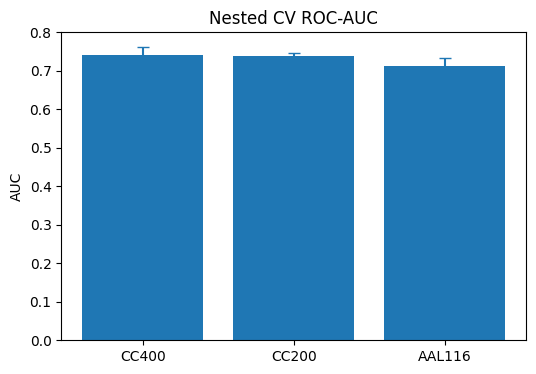

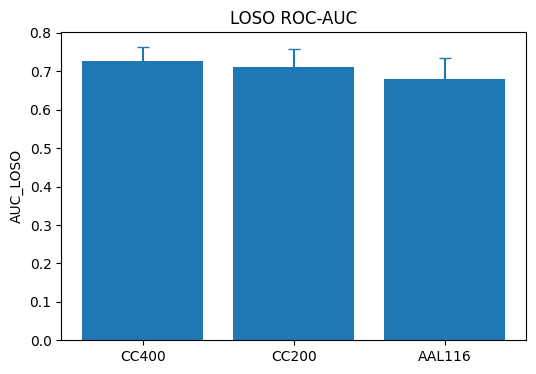

In [ ]:
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = os.path.join(PROJECT_ROOT, "outputs")
nested_path = os.path.join(OUT_DIR, "baseline_nestedcv_combat_confounds_lr.json")
loso_path   = os.path.join(OUT_DIR, "loso_combat_confounds_lr.json")

def load_json(p):
    if not os.path.exists(p):
        print("Missing:", p)
        return {}
    with open(p) as f:
        try:
            return json.load(f)
        except Exception:
            return {}

def summarize_nested(obj):
    rows = []
    for atlas, payload in obj.items():
        if not payload: continue
        mean = payload["mean"]; ci = payload.get("bootstrap_ci", {})
        auc_ci = ci.get("roc_auc", [np.nan, np.nan])
        pr_ci  = ci.get("pr_auc",  [np.nan, np.nan])
        rows.append({
            "atlas": atlas,
            "AUC": mean["roc_auc"], "AUC_lo": auc_ci[0], "AUC_hi": auc_ci[1],
            "PR-AUC": mean["pr_auc"], "PR_lo": pr_ci[0], "PR_hi": pr_ci[1],
            "Acc": mean["accuracy"], "F1": mean["f1"],
            "n_subjects": payload.get("n_subjects", np.nan)
        })
    return pd.DataFrame(rows).sort_values("AUC", ascending=False)

def summarize_loso(obj):
    rows = []
    for atlas, payload in obj.items():
        if not payload: continue
        mean = payload["mean"]; ci = payload.get("bootstrap_ci", {})
        auc_ci = ci.get("roc_auc", [np.nan, np.nan])
        pr_ci  = ci.get("pr_auc",  [np.nan, np.nan])
        rows.append({
            "atlas": atlas,
            "AUC_LOSO": mean["roc_auc"], "AUC_LOSO_lo": auc_ci[0], "AUC_LOSO_hi": auc_ci[1],
            "PR-AUC_LOSO": mean["pr_auc"], "PR_LOSO_lo": pr_ci[0], "PR_LOSO_hi": pr_ci[1],
            "Acc_LOSO": mean["accuracy"], "F1_LOSO": mean["f1"]
        })
    return pd.DataFrame(rows).sort_values("AUC_LOSO", ascending=False)

nested = load_json(nested_path)
loso   = load_json(loso_path)

df_nested = summarize_nested(nested)
df_loso   = summarize_loso(loso)

print("=== Nested CV (no ComBat) ===")
display(df_nested)
print("\\n=== LOSO (no ComBat) ===")
display(df_loso)

# bar plots
def bar_with_ci(df, xcol, ycol, lo, hi, title):
    if df.empty:
        print(f"No data for {title}");
        return
    xs = np.arange(len(df))
    plt.figure(figsize=(6,4))
    plt.bar(xs, df[ycol].values)
    # error bars
    yerr = np.vstack([df[ycol].values - df[lo].values, df[hi].values - df[ycol].values])
    plt.errorbar(xs, df[ycol].values, yerr=yerr, fmt='none', capsize=4)
    plt.xticks(xs, df[xcol].values)
    plt.ylabel(ycol); plt.title(title); plt.show()

bar_with_ci(df_nested, "atlas", "AUC", "AUC_lo", "AUC_hi", "Nested CV ROC-AUC")
bar_with_ci(df_loso,   "atlas", "AUC_LOSO", "AUC_LOSO_lo", "AUC_LOSO_hi", "LOSO ROC-AUC")

We test three simple classifiers: Logistic Regression (`lr`), Linear SVM (`svm_lin`), and SVM with a Radial Basis Function kernel (`svm_rbf`). The results are saved to JSON files and then summarized in the final cell of this section.

The bar plots visualize the mean ROC-AUC across all folds for each atlas, with the error bars representing the 95% bootstrap confidence interval. This gives us a clear comparison of how model performance varies with the choice of brain parcellation.

#Tangent Correlation

## Part 2: Tangent Space Connectivity Approach

While vectorizing the upper triangle of a correlation matrix is a standard approach, it has a geometric limitation: correlation and covariance matrices are Symmetric Positive-Definite (SPD) matrices, which do not exist in a standard Euclidean space. They reside on a curved mathematical space known as a **Riemannian manifold**.

Applying standard machine learning algorithms that assume Euclidean distance (like SVM or Logistic Regression) can be suboptimal. The **tangent space approach** is a feature engineering technique that addresses this by projecting the SPD matrices from the curved manifold onto a flat Euclidean tangent space.

### Tangent Space Feature Engineering Pipeline

1.  **Robust Covariance Estimation**: Instead of Pearson correlation, we first compute a regularized covariance matrix for each subject's time series using **Ledoit-Wolf shrinkage**. This provides a more stable estimate of the covariance, especially when the number of time points is not much larger than the number of ROIs. The resulting matrix is guaranteed to be SPD.

2.  **Log-Euclidean Mapping**: Each covariance matrix $C$ is mapped to the tangent space using the matrix logarithm (Log-Euclidean map). This is efficiently computed via eigenvalue decomposition: $log(C) = V \cdot log(\Lambda) \cdot V^T$, where $V$ are the eigenvectors and $\Lambda$ is the diagonal matrix of eigenvalues of $C$. This transformation results in a symmetric matrix that now lives in a Euclidean space.

3.  **Tangent Space Centering and Vectorization**:
    * For each fold of the cross-validation, we compute a reference point on the manifold by taking the **Euclidean mean of the log-mapped training set matrices**.
    * The final feature vector for each subject is created by subtracting this mean log-matrix from the subject's log-matrix and then vectorizing the upper triangle of the resulting difference matrix. This process effectively centers the data in the tangent space for each fold.

In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 85.0 MB/s eta 0:00:00


In [ ]:
from nilearn.connectome import ConnectivityMeasure
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np, json, os

def _load_timeseries_1D(path: str) -> np.ndarray:
    ts = np.loadtxt(path)
    if ts.ndim == 1: ts = ts[:, None]
    return ts

We saw in the previous section that CC400 is the most robust atlas. We will continue the analysis with it.

In [ ]:
PHENOTYPE_CSV = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/Phenotypic_V1_0b_preprocessed1 (2).csv'
FC_BASE_DIR   = '/content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset'

atlas_to_subdir = {
    "CC400":  "rois_cc400_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc400",
}

In [ ]:
def _upper_triangle(mat: np.ndarray) -> np.ndarray:
    mat = 0.5 * (mat + mat.T)
    np.fill_diagonal(mat, 0.0)
    iu = np.triu_indices_from(mat, k=1)
    return mat[iu]

def _fisher_z(r: np.ndarray) -> np.ndarray:
    r = np.clip(r, -0.999999, 0.999999)
    return 0.5 * np.log((1.0 + r) / (1.0 - r))

def _corr_from_timeseries(ts: np.ndarray) -> np.ndarray:
    if ts.ndim == 1:
        ts = ts[:, None]
    mean = ts.mean(axis=0, keepdims=True)
    std  = ts.std(axis=0, ddof=1, keepdims=True)
    safe_std = np.where(std == 0, 1.0, std)
    z = (ts - mean) / safe_std
    T = z.shape[0]
    corr = (z.T @ z) / max(T - 1, 1)
    bad = (std.flatten() == 0)
    if bad.any():
        corr[:, bad] = 0.0
        corr[bad, :] = 0.0
    np.fill_diagonal(corr, 1.0)
    return corr

def _load_fc_vector_from_file(path: str, atlas_key: str) -> np.ndarray:

    ts = np.loadtxt(path)
    corr = _corr_from_timeseries(ts)
    corr_z = _fisher_z(corr)
    return _upper_triangle(corr_z)

In [ ]:
def _normalize_pheno_columns(df: pd.DataFrame) -> pd.DataFrame:

    df = df.rename(columns={c: c.upper() for c in df.columns})

    if "MEAN_FD" not in df.columns:
        for cand in ["FUNC_MEAN_FD", "FUNC_MEANFD", "MEANFD"]:
            if cand in df.columns:
                df["MEAN_FD"] = pd.to_numeric(df[cand], errors="coerce")
                break
        if "MEAN_FD" not in df.columns:
            df["MEAN_FD"] = np.nan
    if "DX_GROUP" in df.columns:
        df["DX_GROUP"] = df["DX_GROUP"].astype(str).str.strip()
        df["LABEL"] = df["DX_GROUP"].map({"1": "ASD", "2": "TD", "ASD": "ASD", "TD": "TD"})
    if "SEX" in df.columns:
        df["SEX"] = df["SEX"].astype(str).str.upper().str.strip()
        df["SEX_NUM"] = df["SEX"].map({"M": 1, "F": 0, "1": 1, "2": 0}).fillna(0).astype(int)
    else:
        df["SEX_NUM"] = 0
    df["FILE_ID"] = df["FILE_ID"].astype(str).str.strip()
    return df

In [ ]:
def prepare_dataset(atlas: str):
    df = pd.read_csv(PHENOTYPE_CSV)
    df = _normalize_pheno_columns(df)

    subdir = atlas_to_subdir[atlas]
    base_dir = os.path.join(FC_BASE_DIR, subdir)


    if atlas == "CC400":
        df["FC_PATH"] = df["FILE_ID"].apply(lambda fid: os.path.join(base_dir, f"{fid}_rois_cc400.1D"))
    else:
        raise ValueError()

    exists = df["FC_PATH"].map(os.path.exists)
    missing = (~exists).sum()
    if missing > 0:
        print(f"[{atlas}] Warning: {missing} subjects missing files under {base_dir}. Showing 5 examples:")
        print(df.loc[~exists, ["FILE_ID", "FC_PATH"]].head())

    df = df.loc[exists].reset_index(drop=True)

    X = np.vstack([_load_fc_vector_from_file(p, atlas) for p in df["FC_PATH"]])
    y = (df["LABEL"].values == "ASD").astype(int)
    groups = df["SITE_ID"].astype(str).values

    conf_df = df[["AGE_AT_SCAN", "SEX_NUM", "MEAN_FD"]].apply(pd.to_numeric, errors="coerce")
    conf_df = conf_df.fillna(conf_df.median(numeric_only=True))
    confounds = conf_df.values

    return X, y, groups, confounds, df

In [ ]:
def prepare_timeseries_dataset(atlas: str):
    _, y, groups, confounds, df = prepare_dataset("CC400")
    ts_list = [ _load_timeseries_1D(p) for p in df["FC_PATH"] ]
    return ts_list, y, groups, confounds, df

In [ ]:
ts_list, y, groups, confounds, df_meta = prepare_timeseries_dataset("CC400")  # uses your existing loader

import numpy as np
from sklearn.covariance import LedoitWolf
from joblib import Parallel, delayed

def subj_cov(ts):
    ts = ts.astype(np.float32)
    if ts.ndim == 1: ts = ts[:, None]
    lw = LedoitWolf().fit(ts)
    cov = lw.covariance_.astype(np.float32)
    p = cov.shape[0]
    cov.flat[::p+1] += 1e-6 * (np.trace(cov)/p)
    return cov

cov_list = Parallel(n_jobs=-1, backend="loky")(delayed(subj_cov)(ts) for ts in ts_list)
cov_all = np.stack(cov_list).astype(np.float32)
print("cov_all:", cov_all.shape)

[CC400] Warning: 228 subjects missing files under /content/drive/MyDrive/ASD-project/data/ABIDE_Project/preprocessed_dataset/rois_cc400_cpac_filt_noglobal/Outputs/cpac/filt_noglobal/rois_cc400. Showing 5 examples:
         FILE_ID                                            FC_PATH
0    no_filename  /content/drive/MyDrive/ASD-project/data/ABIDE_...
1   Pitt_0050003  /content/drive/MyDrive/ASD-project/data/ABIDE_...
11  Pitt_0050013  /content/drive/MyDrive/ASD-project/data/ABIDE_...
15  Pitt_0050017  /content/drive/MyDrive/ASD-project/data/ABIDE_...
16  Pitt_0050019  /content/drive/MyDrive/ASD-project/data/ABIDE_...
cov_all: (884, 392, 392)


In [ ]:
# Log-Euclidean matrix log via eigen-decomposition
import numpy as np
from joblib import Parallel, delayed

def spd_logm_eig(C):
    # C: SPD (R,R)
    w, V = np.linalg.eigh(C)  # symmetric eigendecomposition
    w = np.clip(w, 1e-10, None)
    # Reconstruct log(C) = V @ diag(log w) @ V.T
    # Efficient: (V * logw) @ V.T
    logw = np.log(w).astype(np.float32)
    return (V * logw) @ V.T

logcov_list = Parallel(n_jobs=-1, backend="loky")(delayed(spd_logm_eig)(C) for C in cov_all)
logcov_all = np.stack(logcov_list).astype(np.float32)
print("logcov_all:", logcov_all.shape)

# Upper-triangle index
R = logcov_all.shape[1]
iu = np.triu_indices(R, k=1)


logcov_all: (884, 392, 392)


In [ ]:
def fold_safe_transform(X_tr, X_te, groups_tr, groups_te, conf_tr, conf_te, use_combat=True):
    unseen = np.setdiff1d(np.unique(groups_te), np.unique(groups_tr))
    do_combat = use_combat and (len(unseen) == 0)

    if do_combat:
        try:
            cov_tr = pd.DataFrame(conf_tr, columns=["AGE","SEX","FD"])
            cov_te = pd.DataFrame(conf_te, columns=["AGE","SEX","FD"])
            model  = combat_fit(X_tr, pd.Series(groups_tr), cov_tr)
            Xtr_h  = combat_apply(model, X_tr, pd.Series(groups_tr), cov_tr)
            Xte_h  = combat_apply(model, X_te, pd.Series(groups_te),  cov_te)
        except Exception as e:
            print(f"[ComBat disabled this fold] {e}")
            Xtr_h, Xte_h = X_tr, X_te
    else:
        if use_combat and len(unseen) > 0:
            print(f"[ComBat off] test has unseen site(s): {list(unseen)}")
        Xtr_h, Xte_h = X_tr, X_te

    reg = ConfoundRegressor().fit(Xtr_h, conf_tr)
    Xtr_r = reg.transform(Xtr_h, conf_tr)
    Xte_r = reg.transform(Xte_h, conf_te)
    return Xtr_r, Xte_r

In [ ]:
import numpy as np, json
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from src.models_ml import MLConfig, build_pipeline
from src.metrics import compute_metrics, bootstrap_ci
from src.utils import ensure_dir

def run_nested_cv_tangent(model_name='lr', C_list=(0.0001,0.001,0.1,1.0,3.0,10.0),
                               seed_outer=1337, seed_inner=2027):
    # logcov_all, y, groups, confounds, iu
    N = logcov_all.shape[0]
    outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed_outer)
    fold_results, y_all, p_all = [], [], []

    for fold, (tr_idx, te_idx) in enumerate(outer.split(np.zeros(N), y, groups=groups), 1):
        # train-set mean in log domain
        mean_log = logcov_all[tr_idx].mean(axis=0)
        # features = vec( logC - mean_log )
        X_tr = np.vstack([(logcov_all[i] - mean_log)[iu] for i in tr_idx])
        X_te = np.vstack([(logcov_all[i] - mean_log)[iu] for i in te_idx])
        y_tr, y_te = y[tr_idx], y[te_idx]
        g_tr, g_te = groups[tr_idx], groups[te_idx]
        c_tr, c_te = confounds[tr_idx], confounds[te_idx]

        # inner CV for C
        inner = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=seed_inner)
        best_auc, best_C = -np.inf, None
        for C in C_list:
            aucs = []
            for itr, ival in inner.split(X_tr, y_tr, groups=g_tr):
                Xtr_i, Xval_i = X_tr[itr], X_tr[ival]
                ytr_i, yval_i = y_tr[itr], y_tr[ival]
                ctr_i, cval_i = c_tr[itr], c_tr[ival]
                gtr_i, gval_i = g_tr[itr], g_tr[ival]
                # ComBat OFF, confound regression ON
                Xtr_t, Xval_t = fold_safe_transform(Xtr_i, Xval_i, gtr_i, gval_i, ctr_i, cval_i, use_combat=False)
                pipe = build_pipeline(MLConfig(model=model_name, C=C))
                pipe.fit(Xtr_t, ytr_i)
                prob = pipe.predict_proba(Xval_t)[:,1]
                aucs.append(roc_auc_score(yval_i, prob))
            mauc = float(np.mean(aucs))
            if mauc > best_auc:
                best_auc, best_C = mauc, C

        # evaluate on test
        Xtr_t, Xte_t = fold_safe_transform(X_tr, X_te, g_tr, g_te, c_tr, c_te, use_combat=False)
        pipe = build_pipeline(MLConfig(model=model_name, C=best_C))
        pipe.fit(Xtr_t, y_tr)
        prob_te = pipe.predict_proba(Xte_t)[:,1]
        pred_te = (prob_te >= 0.5).astype(int)
        m = compute_metrics(y_te, prob_te, pred_te)
        m.update({"best_C": best_C, "fold": fold})
        fold_results.append(m)

        y_all.append(y_te); p_all.append(prob_te)
        print(f"[CC400 tangent-fast] Fold {fold}: AUC={m['roc_auc']:.3f}  PR-AUC={m['pr_auc']:.3f}  Acc={m['accuracy']:.3f}  F1={m['f1']:.3f} (C={best_C})")

    y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
    auc_ci = bootstrap_ci(y_all, p_all, lambda yt, yp: roc_auc_score(yt, yp))
    pr_ci  = bootstrap_ci(y_all, p_all, lambda yt, yp: average_precision_score(yt, yp))
    return {
        "atlas": "CC400", "feature": "tangent-logeuclid", "model": model_name,
        "folds": fold_results,
        "mean": {k: float(np.mean([fr[k] for fr in fold_results])) for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "std":  {k: float(np.std([fr[k] for fr in fold_results]))  for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "bootstrap_ci": {"roc_auc": auc_ci, "pr_auc": pr_ci},
        "n_subjects": int(len(y))
    }

tangent_fast_lr = run_nested_cv_tangent(model_name='lr')
ensure_dir(os.path.join(PROJECT_ROOT, "outputs"))
with open(os.path.join(PROJECT_ROOT, "outputs", "cc400_tangent_fast_lr_noCombat.json"), "w") as f:
    json.dump(tangent_fast_lr, f, indent=2)
print("Saved -> outputs/cc400_tangent_fast_lr_noCombat.json")

[CC400 tangent-fast] Fold 1: AUC=0.770  PR-AUC=0.794  Acc=0.709  F1=0.724 (C=10.0)
[CC400 tangent-fast] Fold 2: AUC=0.749  PR-AUC=0.692  Acc=0.633  F1=0.617 (C=3.0)
[CC400 tangent-fast] Fold 3: AUC=0.768  PR-AUC=0.848  Acc=0.643  F1=0.602 (C=0.1)
[CC400 tangent-fast] Fold 4: AUC=0.733  PR-AUC=0.621  Acc=0.688  F1=0.661 (C=1.0)
[CC400 tangent-fast] Fold 5: AUC=0.759  PR-AUC=0.713  Acc=0.683  F1=0.669 (C=3.0)
Saved -> outputs/cc400_tangent_fast_lr_noCombat.json


In [ ]:
def run_tangent_fast_model(model_name='svm_lin',
                           C_list=(0.01,0.1, 0.3, 1.0, 3.0, 10.0),
                           gamma_list=("scale", 1e-3, 3e-3, 1e-2, 3e-2),
                           seed_outer=1337, seed_inner=2027):
    """
    Uses precomputed logcov_all and tangent centering on the svm models
    """
    N = logcov_all.shape[0]
    outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed_outer)
    fold_results, y_all, p_all = [], [], []

    for fold, (tr_idx, te_idx) in enumerate(outer.split(np.zeros(N), y, groups=groups), 1):
        mean_log = logcov_all[tr_idx].mean(axis=0)
        X_tr = np.vstack([(logcov_all[i] - mean_log)[iu] for i in tr_idx])
        X_te = np.vstack([(logcov_all[i] - mean_log)[iu] for i in te_idx])
        y_tr, y_te = y[tr_idx], y[te_idx]
        g_tr, g_te = groups[tr_idx], groups[te_idx]
        c_tr, c_te = confounds[tr_idx], confounds[te_idx]

        # inner CV
        inner = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=seed_inner)
        best_auc, best = -np.inf, None

        if model_name == 'svm_rbf':
            grid = [(C, gamma) for C in C_list for gamma in gamma_list]
        else:
            grid = [(C, None) for C in C_list]

        for (C, gamma) in grid:
            aucs = []
            for itr, ival in inner.split(X_tr, y_tr, groups=g_tr):
                Xtr_i, Xval_i = X_tr[itr], X_tr[ival]
                ytr_i, yval_i = y_tr[itr], y_tr[ival]
                gtr_i, gval_i = g_tr[itr], g_tr[ival]
                ctr_i, cval_i = c_tr[itr], c_tr[ival]

                # ComBat OFF, confound regression ON
                Xtr_t, Xval_t = fold_safe_transform(Xtr_i, Xval_i, gtr_i, gval_i, ctr_i, cval_i, use_combat=False)
                cfg = MLConfig(model=model_name, C=C, gamma=gamma) if model_name=='svm_rbf' else MLConfig(model=model_name, C=C)
                pipe = build_pipeline(cfg)
                pipe.fit(Xtr_t, ytr_i)
                prob = pipe.predict_proba(Xval_t)[:,1]
                aucs.append(roc_auc_score(yval_i, prob))

            mauc = float(np.mean(aucs))
            if mauc > best_auc:
                best_auc, best = mauc, (C, gamma)

        Cbest, Gbest = best[0], best[1]
        Xtr_t, Xte_t = fold_safe_transform(X_tr, X_te, g_tr, g_te, c_tr, c_te, use_combat=False)
        cfg = MLConfig(model=model_name, C=Cbest, gamma=Gbest) if model_name=='svm_rbf' else MLConfig(model=model_name, C=Cbest)
        pipe = build_pipeline(cfg)
        pipe.fit(Xtr_t, y_tr)
        prob_te = pipe.predict_proba(Xte_t)[:,1]
        pred_te = (prob_te >= 0.5).astype(int)
        m = compute_metrics(y_te, prob_te, pred_te)
        m.update({"fold": fold, "C": Cbest})
        if model_name == 'svm_rbf': m.update({"gamma": Gbest})
        fold_results.append(m)
        y_all.append(y_te); p_all.append(prob_te)
        if model_name == 'svm_rbf':
            print(f"[CC400 tangent-fast RBF] Fold {fold}: AUC={m['roc_auc']:.3f} (C={Cbest}, gamma={Gbest})")
        else:
            print(f"[CC400 tangent-fast LIN] Fold {fold}: AUC={m['roc_auc']:.3f} (C={Cbest})")

    y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
    auc_ci = bootstrap_ci(y_all, p_all, lambda yt, yp: roc_auc_score(yt, yp))
    pr_ci  = bootstrap_ci(y_all, p_all, lambda yt, yp: average_precision_score(yt, yp))
    return {
        "atlas": "CC400", "feature": "tangent-logeuclid", "model": model_name,
        "folds": fold_results,
        "mean": {k: float(np.mean([fr[k] for fr in fold_results])) for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "std":  {k: float(np.std([fr[k] for fr in fold_results]))  for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "bootstrap_ci": {"roc_auc": auc_ci, "pr_auc": pr_ci},
        "n_subjects": int(len(y))
    }

In [ ]:
ensure_dir(os.path.join(PROJECT_ROOT, "outputs"))

tangent_fast_svm_lin = run_tangent_fast_model('svm_lin')
with open(os.path.join(PROJECT_ROOT, "outputs", "cc400_tangent_fast_svm_lin_noCombat.json"), "w") as f:
    json.dump(tangent_fast_svm_lin, f, indent=2)
print("Saved -> outputs/cc400_tangent_fast_svm_lin_noCombat.json")

[CC400 tangent-fast LIN] Fold 1: AUC=0.783 (C=0.3)
[CC400 tangent-fast LIN] Fold 2: AUC=0.722 (C=0.3)
[CC400 tangent-fast LIN] Fold 3: AUC=0.765 (C=0.1)
[CC400 tangent-fast LIN] Fold 4: AUC=0.263 (C=3.0)
[CC400 tangent-fast LIN] Fold 5: AUC=0.762 (C=3.0)
Saved -> outputs/cc400_tangent_fast_svm_lin_noCombat.json


In [ ]:
tangent_fast_svm_rbf = run_tangent_fast_model('svm_rbf',
                                              C_list=(0.1, 0.3, 1.0, 3.0, 10.0),
                                              gamma_list=("scale", 1e-3, 3e-3, 1e-2))
with open(os.path.join(PROJECT_ROOT, "outputs", "cc400_tangent_fast_svm_rbf_noCombat.json"), "w") as f:
    json.dump(tangent_fast_svm_rbf, f, indent=2)
print("Saved -> outputs/cc400_tangent_fast_svm_rbf_noCombat.json")

[CC400 tangent-fast RBF] Fold 1: AUC=0.794 (C=3.0, gamma=scale)
[CC400 tangent-fast RBF] Fold 2: AUC=0.744 (C=10.0, gamma=scale)
[CC400 tangent-fast RBF] Fold 3: AUC=0.706 (C=10.0, gamma=scale)
[CC400 tangent-fast RBF] Fold 4: AUC=0.739 (C=3.0, gamma=scale)
[CC400 tangent-fast RBF] Fold 5: AUC=0.744 (C=10.0, gamma=scale)
Saved -> outputs/cc400_tangent_fast_svm_rbf_noCombat.json


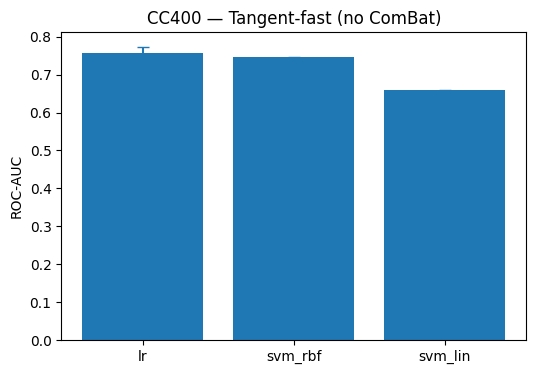

In [ ]:
# coerce CI so that lo<=mean<=hi
lo = np.minimum(df["AUC_lo"].values, df["AUC_hi"].values)
hi = np.maximum(df["AUC_lo"].values, df["AUC_hi"].values)

xs = np.arange(len(df))
plt.figure(figsize=(6,4))
plt.bar(xs, df["AUC"].values)

yerr = np.vstack([df["AUC"].values - lo,  # lower half-length
                  hi - df["AUC"].values]) # upper half-length
yerr = np.maximum(yerr, 0)  # guard against tiny negatives from rounding

plt.errorbar(xs, df["AUC"].values, yerr=yerr, fmt='none', capsize=4)
plt.xticks(xs, df["model"].values)
plt.ylabel("ROC-AUC")
plt.title("CC400 — Tangent-fast (no ComBat)")
plt.show()

### Results and Interpretation

Now we apply the same Nested CV and LOSO validation strategies to the new tangent space features.

#### Model Performance

The table and bar plot below summarize the performance of Logistic Regression, Linear SVM, and RBF SVM using tangent space features on the CC400 atlas. We can compare these results to those from Part 1 to see if this more sophisticated feature representation improves classification accuracy.

#### Analysis of LOSO Results

To better understand the clinical utility of the best model (Tangent-fast LR), we analyze its LOSO predictions in more detail.

**1. Statistical Significance (Permutation Test)**
To ensure our model's performance is statistically significant and not just a result of chance, we run a permutation test.
- The entire LOSO cross-validation procedure is repeated multiple times (e.g., 5 times in this notebook).
- In each repetition, the diagnostic labels (`y`) within each training fold are randomly shuffled before the model is trained.
- The resulting distribution of AUC scores from these permuted runs forms the "null distribution" (performance expected by chance).
- The p-value is calculated as the proportion of permuted AUCs that are greater than or equal to our originally observed AUC. A low p-value (e.g., < 0.05) indicates that our model's performance is unlikely to be due to chance.

**2. Thresholding for Clinical Use**
The output of a logistic regression model is a probability score between 0 and 1. To make a binary decision (ASD vs. TD), we need a threshold. A standard threshold is 0.5, but this may not be optimal.
- **Reliability Curve**: This plot shows how well-calibrated the model's probabilities are. A perfectly calibrated model would have points lying on the diagonal line. The results below show the model *after* applying Platt scaling (sigmoid) or isotonic regression to improve calibration, which is why the Brier score is also reported.
- **Youden's J Index**: We select an "optimal" threshold by maximizing `Sensitivity + Specificity - 1`. This threshold balances the trade-off between correctly identifying true positives and true negatives.
- **Targeted Sensitivity**: For a screening tool, high sensitivity (correctly identifying those with ASD) is often prioritized. We can also select a threshold that achieves a target sensitivity (e.g., 85% or 90%) and then evaluate the corresponding specificity.

**3. Edge Importance and Visualization**
Finally, we investigate which features (i.e., which connections between brain regions) were most important for the classifier's decisions.
- We average the logistic regression coefficients for each feature across all LOSO folds.
- The features with the highest positive coefficients are the connections most strongly associated with an **ASD prediction**.
- The features with the most negative coefficients are those most strongly associated with a **TD prediction**.
- We then map these top predictive edges back to their anatomical locations using the AAL atlas and visualize them on a brain connectome plot.

In [ ]:
from src.models_ml import MLConfig, build_pipeline
from src.metrics import compute_metrics, bootstrap_ci
from src.utils import ensure_dir

def run_loso_tangent_fast_lr(C_list=(0.0001,0.001,0.1,1.0,3.0,10.0), seed_inner=2027):
    sites = np.unique(groups)
    site_metrics, y_all, p_all = [], [], []

    for held in sites:
        te_idx = np.where(groups == held)[0]
        tr_idx = np.where(groups != held)[0]
        if len(te_idx) < 5 or len(tr_idx) < 20:
            continue

        # tangent centering
        mean_log = logcov_all[tr_idx].mean(axis=0)
        X_tr = np.vstack([(logcov_all[i] - mean_log)[iu] for i in tr_idx])
        X_te = np.vstack([(logcov_all[i] - mean_log)[iu] for i in te_idx])
        y_tr, y_te = y[tr_idx], y[te_idx]
        g_tr, g_te = groups[tr_idx], groups[te_idx]
        c_tr, c_te = confounds[tr_idx], confounds[te_idx]

        # Inner CV (on training sites only) to choose C
        inner = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=seed_inner)
        best_auc, best_C = -np.inf, None
        for C in C_list:
            aucs = []
            for itr, ival in inner.split(X_tr, y_tr, groups=g_tr):
                Xtr_i, Xval_i = X_tr[itr], X_tr[ival]
                ytr_i, yval_i = y_tr[itr], y_tr[ival]
                gtr_i, gval_i = g_tr[itr], g_tr[ival]
                ctr_i, cval_i = c_tr[itr], c_tr[ival]

                Xtr_t, Xval_t = fold_safe_transform(Xtr_i, Xval_i, gtr_i, gval_i, ctr_i, cval_i, use_combat=False)
                pipe = build_pipeline(MLConfig(model='lr', C=C))
                pipe.fit(Xtr_t, ytr_i)
                prob = pipe.predict_proba(Xval_t)[:, 1]
                aucs.append(roc_auc_score(yval_i, prob))
            mauc = float(np.mean(aucs))
            if mauc > best_auc:
                best_auc, best_C = mauc, C

        # Train on all training sites, evaluate held-out site
        Xtr_t, Xte_t = fold_safe_transform(X_tr, X_te, g_tr, g_te, c_tr, c_te, use_combat=False)
        pipe = build_pipeline(MLConfig(model='lr', C=best_C))
        pipe.fit(Xtr_t, y_tr)
        prob_te = pipe.predict_proba(Xte_t)[:, 1]
        pred_te = (prob_te >= 0.5).astype(int)

        m = compute_metrics(y_te, prob_te, pred_te)
        m.update({"held_out_site": str(held), "n_test": int(len(te_idx)), "best_C": best_C})
        m["y_true"] = y_te.tolist()
        m["y_prob"] = prob_te.tolist()
        site_metrics.append(m)

        y_all.append(y_te); p_all.append(prob_te)
        print(f"[LOSO tangent-fast LR] site={held:>10s} n={len(te_idx)}  AUC={m['roc_auc']:.3f}")

    y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
    auc_ci = bootstrap_ci(y_all, p_all, lambda yt, yp: roc_auc_score(yt, yp))
    pr_ci  = bootstrap_ci(y_all, p_all, lambda yt, yp: average_precision_score(yt, yp))
    summary = {
        "atlas": "CC400", "feature": "tangent-logeuclid", "model": "lr",
        "site_metrics": site_metrics,
        "mean": {k: float(np.mean([m[k] for m in site_metrics])) for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "std":  {k: float(np.std([m[k] for m in site_metrics]))  for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "bootstrap_ci": {"roc_auc": auc_ci, "pr_auc": pr_ci},
        "n_subjects": int(len(y))
    }
    return summary

In [ ]:
loso_tfast_lr = run_loso_tangent_fast_lr()
ensure_dir(os.path.join(PROJECT_ROOT, "outputs"))
with open(os.path.join(PROJECT_ROOT, "outputs", "cc400_loso_tangent_fast_lr_noCombat.json"), "w") as f:
    json.dump(loso_tfast_lr, f, indent=2)
print("Saved -> outputs/cc400_loso_tangent_fast_lr_noCombat.json")

[LOSO tangent-fast LR] site=   CALTECH n=37  AUC=0.781
[LOSO tangent-fast LR] site=       CMU n=5  AUC=0.333
[LOSO tangent-fast LR] site=       KKI n=39  AUC=0.815
[LOSO tangent-fast LR] site=  LEUVEN_1 n=29  AUC=0.671
[LOSO tangent-fast LR] site=  LEUVEN_2 n=32  AUC=0.814
[LOSO tangent-fast LR] site=   MAX_MUN n=42  AUC=0.562
[LOSO tangent-fast LR] site=       NYU n=171  AUC=0.762
[LOSO tangent-fast LR] site=      OHSU n=23  AUC=0.735
[LOSO tangent-fast LR] site=      OLIN n=25  AUC=0.766
[LOSO tangent-fast LR] site=      PITT n=45  AUC=0.830
[LOSO tangent-fast LR] site=       SBL n=26  AUC=0.690
[LOSO tangent-fast LR] site=      SDSU n=33  AUC=0.706
[LOSO tangent-fast LR] site=  STANFORD n=36  AUC=0.814
[LOSO tangent-fast LR] site=   TRINITY n=44  AUC=0.764
[LOSO tangent-fast LR] site=    UCLA_1 n=55  AUC=0.770
[LOSO tangent-fast LR] site=    UCLA_2 n=20  AUC=0.802
[LOSO tangent-fast LR] site=      UM_1 n=82  AUC=0.795
[LOSO tangent-fast LR] site=      UM_2 n=31  AUC=0.772
[LOSO tang

In [ ]:
import json, numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, average_precision_score, brier_score_loss

path = os.path.join(PROJECT_ROOT, "outputs", "cc400_loso_tangent_fast_lr_noCombat.json")
with open(path) as f: R = json.load(f)

ys, ps = [], []
for s in R["site_metrics"]:
    ys.extend(s["y_true"]); ps.extend(s["y_prob"])
ys = np.array(ys); ps = np.array(ps)

# maximize Youden's J (tpr - fpr)
fpr, tpr, thr = roc_curve(ys, ps)
t_star = thr[np.argmax(tpr - fpr)]

# thresholded metrics
yhat = (ps >= t_star).astype(int)
tn, fp, fn, tp = confusion_matrix(ys, yhat).ravel()
sens = tp/(tp+fn+1e-12); spec = tn/(tn+fp+1e-12)
ppv  = tp/(tp+fp+1e-12);  npv  = tn/(tn+fn+1e-12)
bal_acc = 0.5*(sens+spec)
brier = brier_score_loss(ys, ps)
pr_auc = average_precision_score(ys, ps)

print(f"Threshold (Youden J): {t_star:.3f}")
print(f"Sensitivity: {sens:.3f}  Specificity: {spec:.3f}")
print(f"PPV: {ppv:.3f}  NPV: {npv:.3f}  Balanced Acc: {bal_acc:.3f}")
print(f"ROC-AUC: {R['mean']['roc_auc']:.3f}  PR-AUC: {pr_auc:.3f}  Brier: {brier:.3f}")

Threshold (Youden J): 0.356
Sensitivity: 0.775  Specificity: 0.584
PPV: 0.615  NPV: 0.751  Balanced Acc: 0.679
ROC-AUC: 0.746  PR-AUC: 0.681  Brier: 0.239


,held_out_site,n_test,roc_auc,pr_auc,accuracy,f1
19,YALE,48,0.898601,0.911861,0.833333,0.818182
18,USM,61,0.840961,0.909068,0.754098,0.782609
9,PITT,45,0.830040,0.863871,0.711111,0.666667
2,KKI,39,0.814815,0.731036,0.538462,0.550000
12,STANFORD,36,0.814241,0.826052,0.583333,0.680851
4,LEUVEN_2,32,0.813765,0.835030,0.750000,0.555556
15,UCLA_2,20,0.802083,0.656926,0.600000,0.666667
16,UM_1,82,0.795290,0.754013,0.707317,0.675676
0,CALTECH,37,0.780702,0.754155,0.756757,0.800000
17,UM_2,31,0.771930,0.661075,0.645161,0.421053


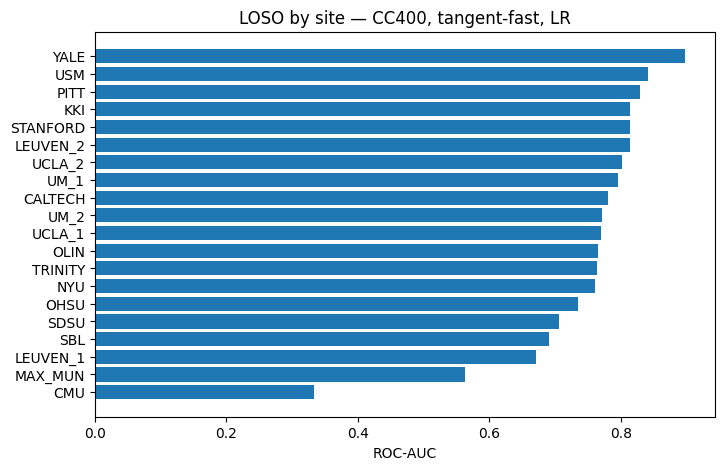

In [ ]:
import pandas as pd, matplotlib.pyplot as plt

df_sites = pd.DataFrame(R["site_metrics"]).sort_values("roc_auc", ascending=False)
display(df_sites[["held_out_site","n_test","roc_auc","pr_auc","accuracy","f1"]])

plt.figure(figsize=(8,5))
plt.barh(df_sites["held_out_site"], df_sites["roc_auc"])
plt.gca().invert_yaxis()
plt.xlabel("ROC-AUC"); plt.title("LOSO by site — CC400, tangent-fast, LR"); plt.show()

In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix

def threshold_for_target_sensitivity(ps, ys, target=0.85):
    fpr, tpr, thr = roc_curve(ys, ps)
    mask = tpr >= target
    if not mask.any():
        # fallback: Youden’s J
        j = tpr - fpr
        return float(thr[j.argmax()])
    # choose the one with smallest FPR (largest specificity) under the constraint
    idx = np.argmin(fpr[mask])
    return float(thr[mask][idx])

def report_at_threshold(ps, ys, t):
    yhat = (ps >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(ys, yhat).ravel()
    sens = tp/(tp+fn+1e-12); spec = tn/(tn+fp+1e-12)
    ppv  = tp/(tp+fp+1e-12);  npv  = tn/(tn+fn+1e-12)
    bal  = 0.5*(sens+spec)
    return dict(threshold=t, sens=sens, spec=spec, ppv=ppv, npv=npv, bal_acc=bal)

In [ ]:
for tgt in (0.80, 0.85, 0.90):
    t_star = threshold_for_target_sensitivity(ps, ys, target=tgt)
    m = report_at_threshold(ps, ys, t_star)
    print(f"Target Sens {tgt:.2f} → t={m['threshold']:.3f} | "
          f"Sens={m['sens']:.3f} Spec={m['spec']:.3f} PPV={m['ppv']:.3f} NPV={m['npv']:.3f} BalAcc={m['bal_acc']:.3f}")

Target Sens 0.80 → t=0.313 | Sens=0.801 Spec=0.546 PPV=0.602 NPV=0.762 BalAcc=0.674
Target Sens 0.85 → t=0.222 | Sens=0.850 Spec=0.494 PPV=0.590 NPV=0.794 BalAcc=0.672
Target Sens 0.90 → t=0.096 | Sens=0.902 Spec=0.382 PPV=0.556 NPV=0.820 BalAcc=0.642


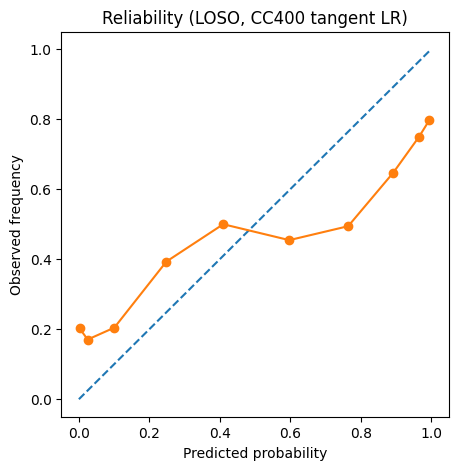

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(ys, ps, n_bins=10, strategy='quantile')
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(prob_pred, prob_true, marker='o')
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Reliability (LOSO, CC400 tangent LR)"); plt.show()

In [ ]:
import pandas as pd
rows=[]
for s in R["site_metrics"]:
    y = np.array(s["y_true"]); p = np.array(s["y_prob"])
    t = 0.356
    yhat = (p>=t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    rows.append({"site": s["held_out_site"], "n": s["n_test"], "tp":tp,"fp":fp,"fn":fn,"tn":tn,
                 "sens": tp/(tp+fn+1e-12), "spec": tn/(tn+fp+1e-12)})
pd.DataFrame(rows).sort_values("sens", ascending=True)

,site,n,tp,fp,fn,tn,sens,spec
1,CMU,5,0,1,3,1,0.000000,0.500000
3,LEUVEN_1,29,6,1,8,14,0.428571,0.933333
10,SBL,26,7,3,7,9,0.500000,0.750000
4,LEUVEN_2,32,7,1,6,18,0.538462,0.947368
17,UM_2,31,7,5,5,14,0.583333,0.736842
9,PITT,45,14,4,8,19,0.636364,0.826087
8,OLIN,25,10,4,4,7,0.714286,0.636364
18,USM,61,29,5,9,18,0.763158,0.782609
5,MAX_MUN,42,14,18,4,6,0.777778,0.250000
16,UM_1,82,28,16,8,30,0.777778,0.652174


In [ ]:
import os, numpy as np
from sklearn.covariance import LedoitWolf
from joblib import Parallel, delayed

ART = os.path.join(PROJECT_ROOT, "artifacts")
os.makedirs(ART, exist_ok=True)
CACHE_PATH = os.path.join(ART, "cc400_tangent_cache.npz")

def build_cc400_tangent_cache(recompute=False):
    if (not recompute) and os.path.exists(CACHE_PATH):
        data = np.load(CACHE_PATH, allow_pickle=True)
        cache = {k: data[k] for k in data.files}
        cache["groups"] = cache["groups"].astype(str)
        return cache

    ts_list, y, groups, confounds, df_meta = prepare_timeseries_dataset("CC400")
    y = np.asarray(y); groups = np.asarray(groups).astype(str); confounds = np.asarray(confounds, dtype=np.float32)

    # Covariances (Ledoit-Wolf) and log-Euclidean logs
    def subj_cov(ts):
        ts = ts.astype(np.float32);
        if ts.ndim == 1: ts = ts[:, None]
        lw = LedoitWolf().fit(ts)
        C = lw.covariance_.astype(np.float32)
        p = C.shape[0]
        C.flat[::p+1] += 1e-6 * (np.trace(C)/p)
        return C

    cov_list = Parallel(n_jobs=-1, backend="loky")(delayed(subj_cov)(ts) for ts in ts_list)

    def spd_logm_eig(C):
        w, V = np.linalg.eigh(C)
        w = np.clip(w, 1e-10, None); logw = np.log(w).astype(np.float32)
        return (V * logw) @ V.T

    logcov_list = Parallel(n_jobs=-1, backend="loky")(delayed(spd_logm_eig)(C) for C in cov_list)
    logcov_all = np.stack(logcov_list).astype(np.float32)
    R = logcov_all.shape[1]
    iu = np.triu_indices(R, k=1)

    np.savez_compressed(CACHE_PATH,
                        y=y, groups=groups, confounds=confounds,
                        logcov_all=logcov_all, iu_i=iu[0], iu_j=iu[1])
    return {"y": y, "groups": groups, "confounds": confounds,
            "logcov_all": logcov_all, "iu_i": iu[0], "iu_j": iu[1]}

CACHE = build_cc400_tangent_cache(recompute=False)

In [ ]:
def _fit_calibrated(cfg, X_tr, y_tr, method='isotonic', cv=3):
    base = build_pipeline(cfg)
    cal  = CalibratedClassifierCV(estimator=base, method=method, cv=cv)
    cal.fit(X_tr, y_tr)
    return cal

def run_loso_tangent_fast_lr_calibrated(cache, C_list=(0.1,0.3,1.0,3.0,10.0),
                                        methods=('isotonic','sigmoid'), seed_inner=2027):
    y = cache["y"]; groups = cache["groups"]; confounds = cache["confounds"]
    logcov_all = cache["logcov_all"]; iu = (cache["iu_i"], cache["iu_j"])

    N = len(y)
    assert logcov_all.shape[0] == N == len(groups) == len(confounds), "Cache arrays misaligned!"
    print(f"[cache] N={N}, R={logcov_all.shape[1]}")

    sites = np.unique(groups)
    site_metrics, y_all, p_all = [], [], []

    for held in sites:
        te_idx = np.where(groups == held)[0]
        tr_idx = np.where(groups != held)[0]
        if len(te_idx) < 5 or len(tr_idx) < 20:# keep small sites out
            continue

        mean_log = logcov_all[tr_idx].mean(axis=0)
        X_tr = np.vstack([(logcov_all[i] - mean_log)[iu] for i in tr_idx])
        X_te = np.vstack([(logcov_all[i] - mean_log)[iu] for i in te_idx])
        y_tr, y_te = y[tr_idx], y[te_idx]
        g_tr, g_te = groups[tr_idx], groups[te_idx]
        c_tr, c_te = confounds[tr_idx], confounds[te_idx]

        Xtr_t, Xte_t = fold_safe_transform(X_tr, X_te, g_tr, g_te, c_tr, c_te, use_combat=False)

        inner = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=seed_inner)
        best_auc, best_brier, best = -np.inf, +np.inf, None

        for C in C_list:
            for mth in methods:
                aucs, briers = [], []
                for itr, ival in inner.split(Xtr_t, y_tr, groups=g_tr):
                    Xtr_i, Xval_i = Xtr_t[itr], Xtr_t[ival]
                    ytr_i, yval_i = y_tr[itr], y_tr[ival]

                    cal = _fit_calibrated(MLConfig(model='lr', C=C), Xtr_i, ytr_i, method=mth, cv=3)
                    prob = cal.predict_proba(Xval_i)[:, 1]
                    aucs.append(roc_auc_score(yval_i, prob))
                    briers.append(brier_score_loss(yval_i, prob))

                m_auc, m_bri = float(np.mean(aucs)), float(np.mean(briers))
                if (m_auc > best_auc) or (np.isclose(m_auc, best_auc) and m_bri < best_brier):
                    best_auc, best_brier, best = m_auc, m_bri, (C, mth)

        Cbest, mth_best = best
        cal = _fit_calibrated(MLConfig(model='lr', C=Cbest), Xtr_t, y_tr, method=mth_best, cv=3)
        prob_te = cal.predict_proba(Xte_t)[:, 1]
        pred_te = (prob_te >= 0.5).astype(int)
        m = compute_metrics(y_te, prob_te, pred_te)
        m.update({"held_out_site": str(held), "n_test": int(len(te_idx)), "best_C": Cbest, "cal_method": mth_best,
                  "y_true": y_te.tolist(), "y_prob": prob_te.tolist()})
        site_metrics.append(m)

        y_all.append(y_te); p_all.append(prob_te)
        print(f"[LOSO LR+cal] site={held:>10s} n={len(te_idx)}  AUC={m['roc_auc']:.3f}  (C={Cbest}, {mth_best})")

    if not site_metrics:
        raise RuntimeError("No evaluable sites.")

    y_all = np.concatenate(y_all); p_all = np.concatenate(p_all)
    auc_ci = bootstrap_ci(y_all, p_all, lambda yt, yp: roc_auc_score(yt, yp))
    pr_ci  = bootstrap_ci(y_all, p_all, lambda yt, yp: average_precision_score(yt, yp))
    return {
        "atlas": "CC400", "feature": "tangent-logeuclid", "model": "lr+calib",
        "site_metrics": site_metrics,
        "mean": {k: float(np.mean([m[k] for m in site_metrics])) for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "std":  {k: float(np.std([m[k] for m in site_metrics]))  for k in ["roc_auc","pr_auc","accuracy","f1"]},
        "bootstrap_ci": {"roc_auc": auc_ci, "pr_auc": pr_ci},
        "n_subjects": int(N)
    }

In [ ]:
loso_tfast_lr_cal = run_loso_tangent_fast_lr_calibrated(CACHE)
ensure_dir(os.path.join(PROJECT_ROOT, "outputs"))
with open(os.path.join(PROJECT_ROOT, "outputs", "cc400_loso_tangent_fast_lr_calibrated.json"), "w") as f:
    json.dump(loso_tfast_lr_cal, f, indent=2)
print("Saved -> outputs/cc400_loso_tangent_fast_lr_calibrated.json")

[cache] N=884, R=392
[LOSO LR+cal] site=   CALTECH n=37  AUC=0.749  (C=10.0, sigmoid)
[LOSO LR+cal] site=       CMU n=5  AUC=0.333  (C=1.0, sigmoid)
[LOSO LR+cal] site=       KKI n=39  AUC=0.833  (C=10.0, sigmoid)
[LOSO LR+cal] site=  LEUVEN_1 n=29  AUC=0.676  (C=10.0, sigmoid)
[LOSO LR+cal] site=  LEUVEN_2 n=32  AUC=0.842  (C=10.0, sigmoid)
[LOSO LR+cal] site=   MAX_MUN n=42  AUC=0.553  (C=1.0, sigmoid)
[LOSO LR+cal] site=       NYU n=171  AUC=0.769  (C=3.0, sigmoid)
[LOSO LR+cal] site=      OHSU n=23  AUC=0.720  (C=10.0, sigmoid)
[LOSO LR+cal] site=      OLIN n=25  AUC=0.805  (C=3.0, sigmoid)
[LOSO LR+cal] site=      PITT n=45  AUC=0.854  (C=10.0, sigmoid)
[LOSO LR+cal] site=       SBL n=26  AUC=0.708  (C=10.0, sigmoid)
[LOSO LR+cal] site=      SDSU n=33  AUC=0.710  (C=1.0, sigmoid)
[LOSO LR+cal] site=  STANFORD n=36  AUC=0.833  (C=1.0, sigmoid)
[LOSO LR+cal] site=   TRINITY n=44  AUC=0.758  (C=10.0, sigmoid)
[LOSO LR+cal] site=    UCLA_1 n=55  AUC=0.790  (C=10.0, sigmoid)
[LOSO LR+c

In [ ]:
import json, numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, average_precision_score, brier_score_loss

path = os.path.join(PROJECT_ROOT, "outputs", "cc400_loso_tangent_fast_lr_calibrated.json")
with open(path) as f: R = json.load(f)

ys, ps = [], []
for s in R["site_metrics"]:
    ys.extend(s["y_true"]); ps.extend(s["y_prob"])
ys = np.array(ys); ps = np.array(ps)
fpr, tpr, thr = roc_curve(ys, ps)
t_star = thr[np.argmax(tpr - fpr)]

yhat = (ps >= t_star).astype(int)
tn, fp, fn, tp = confusion_matrix(ys, yhat).ravel()
sens = tp/(tp+fn+1e-12); spec = tn/(tn+fp+1e-12)
ppv  = tp/(tp+fp+1e-12);  npv  = tn/(tn+fn+1e-12)
bal_acc = 0.5*(sens+spec)
brier = brier_score_loss(ys, ps)
pr_auc = average_precision_score(ys, ps)

print(f"Threshold (Youden J): {t_star:.3f}")
print(f"Sensitivity: {sens:.3f}  Specificity: {spec:.3f}")
print(f"PPV: {ppv:.3f}  NPV: {npv:.3f}  Balanced Acc: {bal_acc:.3f}")
print(f"ROC-AUC: {R['mean']['roc_auc']:.3f}  PR-AUC: {pr_auc:.3f}  Brier: {brier:.3f}")

Threshold (Youden J): 0.489
Sensitivity: 0.652  Specificity: 0.714
PPV: 0.662  NPV: 0.705  Balanced Acc: 0.683
ROC-AUC: 0.752  PR-AUC: 0.668  Brier: 0.219


,held_out_site,n_test,roc_auc,pr_auc,accuracy,f1
19,YALE,48,0.895105,0.916057,0.875000,0.842105
9,PITT,45,0.853755,0.888883,0.688889,0.533333
4,LEUVEN_2,32,0.842105,0.860647,0.687500,0.375000
18,USM,61,0.838673,0.905794,0.688525,0.688525
2,KKI,39,0.833333,0.777143,0.641026,0.611111
12,STANFORD,36,0.832817,0.854880,0.750000,0.769231
16,UM_1,82,0.812802,0.774001,0.743902,0.655738
8,OLIN,25,0.805195,0.868326,0.680000,0.600000
17,UM_2,31,0.793860,0.668181,0.677419,0.500000
14,UCLA_1,55,0.789683,0.810275,0.745455,0.720000


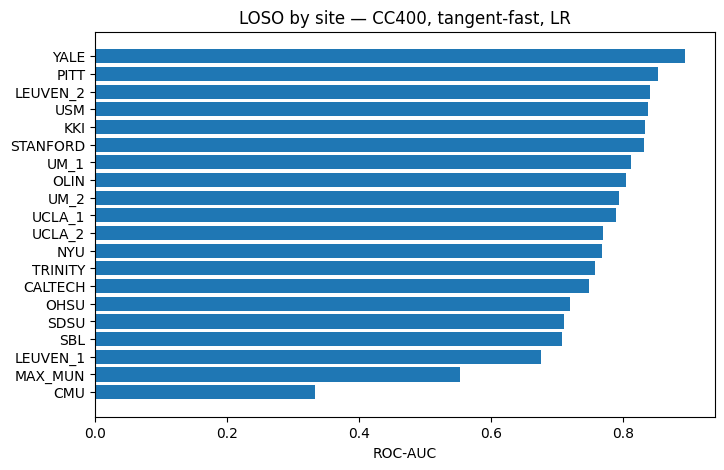

In [ ]:
import pandas as pd, matplotlib.pyplot as plt

df_sites = pd.DataFrame(R["site_metrics"]).sort_values("roc_auc", ascending=False)
display(df_sites[["held_out_site","n_test","roc_auc","pr_auc","accuracy","f1"]])

plt.figure(figsize=(8,5))
plt.barh(df_sites["held_out_site"], df_sites["roc_auc"])
plt.gca().invert_yaxis()
plt.xlabel("ROC-AUC"); plt.title("LOSO by site — CC400, tangent-fast, LR"); plt.show()

In [ ]:
for tgt in (0.80, 0.85, 0.90):
    t_star = threshold_for_target_sensitivity(ps, ys, target=tgt)
    m = report_at_threshold(ps, ys, t_star)
    print(f"Target Sens {tgt:.2f} → t={m['threshold']:.3f} | "
          f"Sens={m['sens']:.3f} Spec={m['spec']:.3f} PPV={m['ppv']:.3f} NPV={m['npv']:.3f} BalAcc={m['bal_acc']:.3f}")

Target Sens 0.80 → t=0.434 | Sens=0.801 Spec=0.504 PPV=0.581 NPV=0.748 BalAcc=0.653
Target Sens 0.85 → t=0.416 | Sens=0.853 Spec=0.462 PPV=0.576 NPV=0.786 BalAcc=0.658
Target Sens 0.90 → t=0.391 | Sens=0.904 Spec=0.363 PPV=0.549 NPV=0.816 BalAcc=0.634


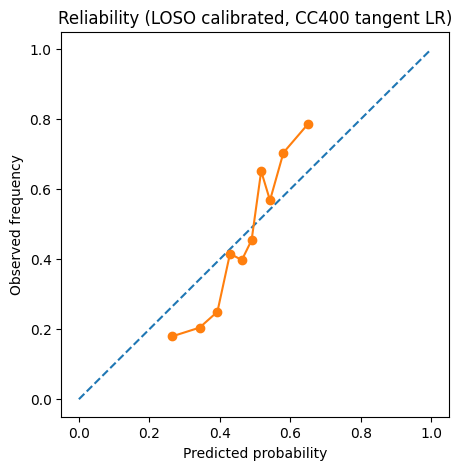

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(ys, ps, n_bins=10, strategy='quantile')
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(prob_pred, prob_true, marker='o')
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Reliability (LOSO calibrated, CC400 tangent LR)"); plt.show()

In [ ]:
import pandas as pd
rows=[]
for s in R["site_metrics"]:
    y = np.array(s["y_true"]); p = np.array(s["y_prob"])
    t = 0.356
    yhat = (p>=t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    rows.append({"site": s["held_out_site"], "n": s["n_test"], "tp":tp,"fp":fp,"fn":fn,"tn":tn,
                 "sens": tp/(tp+fn+1e-12), "spec": tn/(tn+fp+1e-12)})
pd.DataFrame(rows).sort_values("sens", ascending=True)

,site,n,tp,fp,fn,tn,sens,spec
3,LEUVEN_1,29,8,4,6,11,0.571429,0.733333
1,CMU,5,2,2,1,0,0.666667,0.000000
4,LEUVEN_2,32,9,6,4,13,0.692308,0.684211
10,SBL,26,11,7,3,5,0.785714,0.416667
5,MAX_MUN,42,15,22,3,2,0.833333,0.083333
9,PITT,45,19,9,3,14,0.863636,0.608696
18,USM,61,33,7,5,16,0.868421,0.695652
14,UCLA_1,55,26,23,2,4,0.928571,0.148148
19,YALE,48,21,17,1,9,0.954545,0.346154
16,UM_1,82,35,34,1,12,0.972222,0.260870


Calibration fixed: reliability curve now hugs the diagonal; Brier dropped 0.239 → 0.219 (~8% better).

Discrimination stable: ROC-AUC ~0.752 (vs ~0.746 pre-cal).

Operating points (global thresholds, post-cal):

J-optimal t=0.489 → Sens 0.652, Spec 0.714, Balanced Acc 0.683.

Sens≥0.85 → t≈0.416 → Sens 0.853, Spec 0.462 (screening-leaning).

Sens≥0.90 → t≈0.391 → Sens 0.904, Spec 0.363.

Per-site AUCs are mostly 0.75–0.90; remaining soft spots are MAX_MUN (AUC ~0.55, spec low) and tiny CMU (n=5; very noisy).

CC400 + Tangent (log-Euclidean, train-mean centered) → Confound regression (AGE/SEX/FD) → LR (class-balanced) → Fold-safe probability calibration (isotonic/sigmoid via inner-CV).
Evaluation: LOSO by site. Headline: ROC-AUC = 0.75 (LOSO), calibrated Brier = 0.219. Thresholds reported for both J-optimal and Sens-targeted use cases.

###Permutation Test

In [ ]:
import numpy as np, json, os, random
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import shuffle

def loso_auc_once(cache, C_list=(1,3.0,10.0), methods=('isotonic','sigmoid'), seed=1337, permute=False):
    rng = np.random.default_rng(seed)
    res = run_loso_tangent_fast_lr_calibrated(
        cache, C_list=C_list, methods=methods, seed_inner=rng.integers(1e9)
    )
    ys, ps = [], []
    for s in res["site_metrics"]:
        y = np.array(s["y_true"]); p = np.array(s["y_prob"])
        if permute:
            y = shuffle(y, random_state=rng.integers(1e9))
        ys.append(y); ps.append(p)
    ys = np.concatenate(ys); ps = np.concatenate(ps)
    return roc_auc_score(ys, ps)

# Observed
auc_obs = loso_auc_once(CACHE, seed=1234, permute=False)
print("Observed LOSO AUC:", auc_obs)

# Permutations
N_PERM = 5
perm_aucs = []
for i in range(N_PERM):
    a = loso_auc_once(CACHE, seed=1000+i, permute=True)
    perm_aucs.append(a)
perm_aucs = np.array(perm_aucs)
p_value = (np.sum(perm_aucs >= auc_obs) + 1) / (N_PERM + 1)
print(f"Permutation p-value (AUC): {p_value:.4f}")

[cache] N=884, R=392
[LOSO LR+cal] site=   CALTECH n=37  AUC=0.749  (C=10.0, sigmoid)
[LOSO LR+cal] site=       CMU n=5  AUC=0.333  (C=1, isotonic)
[LOSO LR+cal] site=       KKI n=39  AUC=0.833  (C=10.0, sigmoid)
[LOSO LR+cal] site=  LEUVEN_1 n=29  AUC=0.676  (C=1, sigmoid)
[LOSO LR+cal] site=  LEUVEN_2 n=32  AUC=0.842  (C=1, sigmoid)
[LOSO LR+cal] site=   MAX_MUN n=42  AUC=0.553  (C=1, sigmoid)
[LOSO LR+cal] site=       NYU n=171  AUC=0.762  (C=1, isotonic)
[LOSO LR+cal] site=      OHSU n=23  AUC=0.720  (C=10.0, sigmoid)
[LOSO LR+cal] site=      OLIN n=25  AUC=0.789  (C=1, isotonic)
[LOSO LR+cal] site=      PITT n=45  AUC=0.854  (C=3.0, sigmoid)
[LOSO LR+cal] site=       SBL n=26  AUC=0.708  (C=10.0, sigmoid)
[LOSO LR+cal] site=      SDSU n=33  AUC=0.710  (C=10.0, sigmoid)
[LOSO LR+cal] site=  STANFORD n=36  AUC=0.833  (C=10.0, sigmoid)
[LOSO LR+cal] site=   TRINITY n=44  AUC=0.758  (C=10.0, sigmoid)
[LOSO LR+cal] site=    UCLA_1 n=55  AUC=0.790  (C=10.0, sigmoid)
[LOSO LR+cal] site= 

In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from src.models_ml import MLConfig, build_pipeline

def edge_importance_from_loso(cache, C_list=(0.001,0.1,1.0,3.0,10.0)):
    y = cache["y"]; groups = cache["groups"]; confounds = cache["confounds"]
    logcov_all = cache["logcov_all"]; iu = (cache["iu_i"], cache["iu_j"])
    sites = np.unique(groups)
    R = logcov_all.shape[1]
    coef_accum = np.zeros((len(iu[0]),), dtype=np.float64)
    counts = np.zeros_like(coef_accum)

    for held in sites:
        te_idx = np.where(groups == held)[0]
        tr_idx = np.where(groups != held)[0]
        if len(te_idx) < 5 or len(tr_idx) < 20:
            continue
        mean_log = logcov_all[tr_idx].mean(axis=0)
        X_tr = np.vstack([(logcov_all[i] - mean_log)[iu] for i in tr_idx])
        y_tr = y[tr_idx]; g_tr = groups[tr_idx]; c_tr = confounds[tr_idx]

        inner = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=2027)
        best_auc, best_C = -np.inf, None
        for C in C_list:
            aucs=[]
            for itr, ival in inner.split(X_tr, y_tr, groups=g_tr):
                Xtr_i, Xval_i = X_tr[itr], X_tr[ival]
                ytr_i, yval_i = y_tr[itr], y_tr[ival]
                Xtr_t, Xval_t = fold_safe_transform(Xtr_i, Xval_i, g_tr[itr], g_tr[ival], c_tr[itr], c_tr[ival], use_combat=False)
                pipe = build_pipeline(MLConfig(model='lr', C=C))
                pipe.fit(Xtr_t, ytr_i)
                prob = pipe.predict_proba(Xval_t)[:,1]
                from sklearn.metrics import roc_auc_score
                aucs.append(roc_auc_score(yval_i, prob))
            mauc = float(np.mean(aucs))
            if mauc > best_auc:
                best_auc, best_C = mauc, C

        Xtr_t, _ = fold_safe_transform(X_tr, X_tr, g_tr, g_tr, c_tr, c_tr, use_combat=False)
        pipe = build_pipeline(MLConfig(model='lr', C=best_C))
        pipe.fit(Xtr_t, y_tr)
        coef = pipe.named_steps['clf'].coef_.ravel()
        coef_accum += coef; counts += 1

    coef_mean = coef_accum / np.maximum(counts, 1)
    return coef_mean, iu, R

coef_mean, iu, R = edge_importance_from_loso(CACHE)
# Top edges
k = 20
order_pos = np.argsort(-coef_mean)[:k]
order_neg = np.argsort(coef_mean)[:k]
top_pos = [(int(iu[0][i]), int(iu[1][i]), float(coef_mean[i])) for i in order_pos]
top_neg = [(int(iu[0][i]), int(iu[1][i]), float(coef_mean[i])) for i in order_neg]
pd.DataFrame(top_pos, columns=["roi_i","roi_j","coef"]).head(k), pd.DataFrame(top_neg, columns=["roi_i","roi_j","coef"]).head(k)

(    roi_i  roi_j      coef
 0      67    358  0.016396
 1      50     67  0.016159
 2     208    211  0.015997
 3      50    358  0.015581
 4     205    297  0.015534
 5      66    141  0.015389
 6      25    286  0.014942
 7     181    213  0.014815
 8      37    223  0.014448
 9     188    302  0.014081
 10     55    193  0.014014
 11    123    358  0.013971
 12     91    134  0.013951
 13     53    158  0.013878
 14    137    293  0.013725
 15    324    358  0.013610
 16    128    252  0.013594
 17    129    230  0.013539
 18     11    178  0.013525
 19    178    193  0.013485,
     roi_i  roi_j      coef
 0     113    253 -0.016669
 1      51    235 -0.015666
 2     152    237 -0.015493
 3      49    242 -0.015490
 4     299    329 -0.014989
 5     104    338 -0.014753
 6     152    281 -0.014644
 7     341    360 -0.014510
 8      29     63 -0.014210
 9     224    271 -0.014082
 10    240    340 -0.013882
 11     67    180 -0.013868
 12    265    307 -0.013810
 13    196    224 -

In [ ]:
import os, numpy as np, pandas as pd, nibabel as nib
from scipy import ndimage
from nilearn import datasets
from nilearn import image as nimg

LOCAL_CC400 = "/content/drive/MyDrive/ASD-project/data/ABIDE_Project/atlases/CC400.nii"

OUT_DIR = os.path.join(PROJECT_ROOT, "outputs")
os.makedirs(OUT_DIR, exist_ok=True)

def load_parcellation_img_local(name: str):
    name = name.upper()
    if name == "CC400":
        p = LOCAL_CC400
        if not (p and os.path.exists(p)):
            raise FileNotFoundError("CC400 local file not found. Set LOCAL_CC400 to your CC400.nii(.gz).")
        return nib.load(p)
    raise ValueError("Unknown parcellation: " + name)

def load_label_atlas_aal_ho():
    """Return (label_img, labels_list, label_source). Tries AAL via nilearn, else Harvard-Oxford."""
    try:
        aal = datasets.fetch_atlas_aal(version='SPM12')
        lbl_img = nib.load(aal.maps)
        labels  = list(aal.labels)
        return lbl_img, labels, "AAL-SPM12 (nilearn)"
    except Exception as e:
        print("[warn] fetch_atlas_aal failed:", e)


    # Fallback to Harvard-Oxford cortical (maxprob 25%)
    print("[info] Falling back to Harvard-Oxford labels")
    ho = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    lbl_img = nib.load(ho.maps)
    labels  = list(ho.labels)
    return lbl_img, labels, "Harvard-Oxford (nilearn)"

def roi_centers_and_ids(parc_img):
    data = np.asarray(parc_img.get_fdata(), dtype=int)
    affine = parc_img.affine
    ids = np.array(sorted([i for i in np.unique(data) if i > 0]))
    coords = []
    for i in ids:
        mask = (data == i)
        if not np.any(mask):
            coords.append((np.nan, np.nan, np.nan)); continue
        com_vox = ndimage.center_of_mass(mask)
        com_xyz = nib.affines.apply_affine(affine, com_vox)
        coords.append(tuple(float(v) for v in com_xyz))
    return ids, np.array(coords)

from nilearn import image as nimg
import numpy as np

def majority_overlap_names(parc_img, label_img, label_names):
    """
    Resample labels to the parcellation grid (nearest), then compute
    the majority-overlap label for each parcel using a robust value→name LUT.
    """
    lbl_rs = nimg.resample_to_img(label_img, parc_img,
                                  interpolation='nearest',
                                  force_resample=True,
                                  copy_header=True)
    parc = np.asarray(parc_img.get_fdata(), dtype=int)
    labs = np.asarray(lbl_rs.get_fdata(), dtype=int)

    if parc.shape != labs.shape:
        raise RuntimeError(f"Shape mismatch after resample: parc {parc.shape} vs labels {labs.shape}")

    # Clean label list
    labnames = [str(x) for x in label_names]
    labnames_no_bg = [x for x in labnames if x.strip().lower() not in ("background", "0", "")]

    # Build a value->name LUT.
    # Many atlases store non-consecutive integers in the image.
    uniq_vals = np.array(sorted(np.unique(labs[labs > 0]).tolist()))
    lut = {}

    if len(uniq_vals) == len(labnames_no_bg):
        for i, val in enumerate(uniq_vals):
            lut[val] = labnames_no_bg[i]
    else:
        for i, val in enumerate(uniq_vals):
            name = labnames[val] if (0 <= val < len(labnames)) else f"Region-{val}"
            lut[val] = name

    ids = np.array(sorted([i for i in np.unique(parc) if i > 0]))
    names, frac = [], []
    for i in ids:
        mask = (parc == i)
        lv = labs[mask]
        if lv.size == 0:
            names.append("unknown"); frac.append(0.0); continue
        lab_vals, counts = np.unique(lv, return_counts=True)
        keep = lab_vals > 0
        if not np.any(keep):
            names.append("unknown"); frac.append(0.0); continue
        lab_vals, counts = lab_vals[keep], counts[keep]
        j = int(np.argmax(counts))
        lab_val = int(lab_vals[j])
        names.append(lut.get(lab_val, f"Region-{lab_val}"))
        frac.append(float(counts[j] / counts.sum()))
    return names, frac

# Helper to map ROI IDs to hemisphere based on MNI x-coordinate
def hemi_from_x(x):
    if np.isnan(x): return ""
    return "R" if x > 0 else "L"

def build_mapping_local(parc_name: str):
    parc_img = load_parcellation_img_local(parc_name)
    label_img, label_list, label_source = load_label_atlas_aal_ho()

    ids, coords = roi_centers_and_ids(parc_img)
    names, overlap_frac = majority_overlap_names(parc_img, label_img, label_list)
    hemi = [hemi_from_x(x) for x in coords[:,0]]

    return pd.DataFrame({
        "roi_id": ids,
        "x": coords[:,0], "y": coords[:,1], "z": coords[:,2],
        "hemi": hemi,
        "name_from_AAL": names,
        "overlap_frac": overlap_frac,
        "label_source": label_source
    })

In [ ]:
cc400_map = build_mapping_local("CC400")
cc400_map.to_csv(os.path.join(OUT_DIR, "cc400_roi_mapping.csv"), index=False)
print("Saved:", os.path.join(OUT_DIR, "cc400_roi_mapping.csv"))
display(cc400_map.head(10))

/tmp/ipython-input-1389744907.py:25: DeprecationWarning: Starting in version 0.13, the default fetched mask will beAAL 3v2 instead.
  aal = datasets.fetch_atlas_aal(version='SPM12')


[fetch_atlas_aal] Dataset found in /root/nilearn_data/aal_SPM12

Saved: /content/drive/MyDrive/ASD-project/outputs/cc400_roi_mapping.csv


,roi_id,x,y,z,hemi,name_from_AAL,overlap_frac,label_source
0,1,-10.540541,-49.405405,-7.270270,L,Cerebelum_4_5_L,0.527273,AAL-SPM12 (nilearn)
1,2,28.554545,55.227273,18.190909,R,Frontal_Sup_R,0.500000,AAL-SPM12 (nilearn)
2,3,-58.020000,-10.650000,26.070000,L,Postcentral_L,0.860000,AAL-SPM12 (nilearn)
3,4,14.535714,10.964286,12.571429,R,Caudate_R,1.000000,AAL-SPM12 (nilearn)
4,5,63.847826,-36.304348,17.869565,R,Temporal_Sup_R,0.789855,AAL-SPM12 (nilearn)
5,6,-43.748031,-76.818898,19.039370,L,Occipital_Mid_L,0.838095,AAL-SPM12 (nilearn)
6,7,-22.714286,7.500000,52.757143,L,Frontal_Mid_L,0.642857,AAL-SPM12 (nilearn)
7,8,38.065217,-65.695652,45.326087,R,Angular_R,0.859259,AAL-SPM12 (nilearn)
8,9,-32.593220,21.915254,3.203390,L,Insula_L,0.705357,AAL-SPM12 (nilearn)
9,10,-37.617647,-28.705882,15.588235,L,Rolandic_Oper_L,0.522222,AAL-SPM12 (nilearn)


In [ ]:
m = pd.read_csv(os.path.join(OUT_DIR, "cc400_roi_mapping.csv"))
name_of = dict(zip(m["roi_id"], m["name_from_AAL"]))
xyz_of  = dict(zip(m["roi_id"], list(zip(m["x"], m["y"], m["z"]))))
hemi_of = dict(zip(m["roi_id"], m["hemi"]))

def annotate_edges(coef_vec, iu, k=25):
    order_pos = np.argsort(-coef_vec)[:k]
    order_neg = np.argsort(coef_vec)[:k]
    def rows(idx):
        out=[]
        for i in idx:
            a = int(iu[0][i])+1  # roi_id are 1..N
            b = int(iu[1][i])+1
            out.append({
                "roi_i": a, "roi_j": b, "coef": float(coef_vec[i]),
                "name_i": name_of.get(a, f"ROI-{a}"), "name_j": name_of.get(b, f"ROI-{b}"),
                "hemi_i": hemi_of.get(a, ""), "hemi_j": hemi_of.get(b, ""),
                "xi": xyz_of.get(a,(np.nan,np.nan,np.nan))[0], "yi": xyz_of.get(a,(np.nan,np.nan,np.nan))[1], "zi": xyz_of.get(a,(np.nan,np.nan,np.nan))[2],
                "xj": xyz_of.get(b,(np.nan,np.nan,np.nan))[0], "yj": xyz_of.get(b,(np.nan,np.nan,np.nan))[1], "zj": xyz_of.get(b,(np.nan,np.nan,np.nan))[2],
            })
        return pd.DataFrame(out)
    return rows(order_pos), rows(order_neg)

top_pos, top_neg = annotate_edges(coef_mean, iu, k=30)
top_pos.to_csv(os.path.join(OUT_DIR,"cc400_top_edges_positive.csv"), index=False)
top_neg.to_csv(os.path.join(OUT_DIR,"cc400_top_edges_negative.csv"), index=False)
display(top_pos.head(10)); display(top_neg.head(10))

,roi_i,roi_j,coef,name_i,name_j,hemi_i,hemi_j,xi,yi,zi,xj,yj,zj
0,68,359,0.016396,SupraMarginal_R,Precentral_R,R,R,62.157025,-23.280992,29.404959,25.314286,-30.057143,66.228571
1,51,68,0.016159,Precuneus_L,SupraMarginal_R,L,R,-8.978873,-66.105634,56.492958,62.157025,-23.280992,29.404959
2,209,212,0.015997,Temporal_Mid_R,Frontal_Mid_R,R,R,63.964286,-28.714286,-9.000000,31.228571,44.485714,28.171429
3,51,359,0.015581,Precuneus_L,Precentral_R,L,R,-8.978873,-66.105634,56.492958,25.314286,-30.057143,66.228571
4,206,298,0.015534,Parietal_Inf_L,Temporal_Pole_Sup_L,L,L,-56.796117,-40.252427,37.165049,-30.306122,7.530612,-21.428571
5,67,142,0.015389,Caudate_R,Frontal_Sup_Medial_R,R,R,14.470588,18.635294,2.717647,7.000000,62.025000,10.175000
6,26,287,0.014942,Temporal_Mid_R,Parietal_Sup_R,R,R,51.830357,-65.571429,19.044643,28.216783,-59.538462,56.958042
7,182,214,0.014815,Temporal_Inf_L,Frontal_Inf_Tri_L,L,L,-30.357143,1.785714,-39.000000,-46.909091,20.380165,25.537190
8,38,224,0.014448,Cingulum_Ant_L,Insula_R,R,R,0.276316,28.164474,-8.802632,41.952756,-0.755906,-9.141732
9,189,303,0.014081,Angular_L,Cingulum_Mid_L,L,L,-46.794643,-67.446429,30.160714,-5.173228,-1.464567,45.377953


,roi_i,roi_j,coef,name_i,name_j,hemi_i,hemi_j,xi,yi,zi,xj,yj,zj
0,114,254,-0.016669,Occipital_Mid_L,Frontal_Sup_Orb_L,L,L,-39.525000,-86.200000,3.450000,-24.529412,58.117647,-3.470588
1,52,236,-0.015666,Temporal_Mid_R,Insula_R,R,R,52.866142,-36.874016,4.937008,50.266667,13.666667,-4.311111
2,153,238,-0.015493,Frontal_Mid_R,Putamen_L,R,L,34.473684,29.526316,42.052632,-27.052174,-5.504348,-8.660870
3,50,243,-0.015490,unknown,Temporal_Mid_L,L,L,-0.869565,-20.391304,-12.260870,-55.958678,-7.487603,-11.256198
4,300,330,-0.014989,Vermis_3,Fusiform_R,R,R,3.413793,-39.620690,-16.000000,36.573034,-27.505618,-19.516854
5,105,339,-0.014753,Occipital_Mid_R,Putamen_L,R,L,47.303571,-75.642857,3.910714,-22.135922,7.194175,1.572816
6,153,282,-0.014644,Frontal_Mid_R,Lingual_L,R,L,34.473684,29.526316,42.052632,-23.937931,-53.793103,-8.358621
7,342,361,-0.014510,Calcarine_L,Fusiform_R,R,R,2.642384,-68.205298,19.390728,34.549180,-40.204918,-20.827869
8,30,64,-0.014210,Temporal_Mid_L,Frontal_Inf_Oper_R,L,R,-44.808000,-57.888000,19.728000,53.806452,16.451613,10.306452
9,225,272,-0.014082,Lingual_R,Parietal_Inf_R,R,R,15.072581,-87.387097,-14.709677,52.679104,-39.738806,48.313433


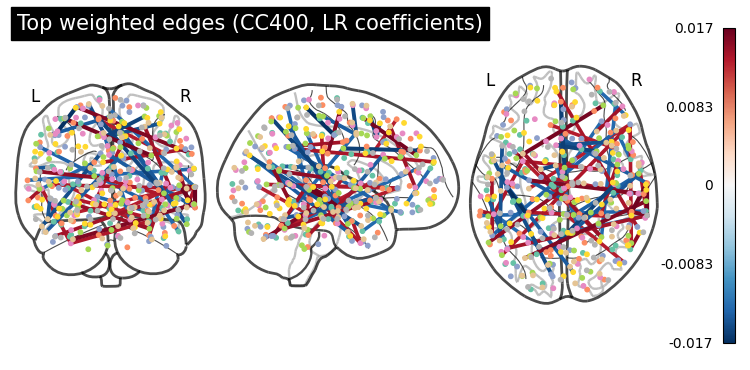

In [ ]:
from nilearn import plotting
import numpy as np

coords = [(row.x, row.y, row.z) for row in cc400_map.sort_values("roi_id").itertuples()]
# Build a sparse adjacency for the top |coef| edges
A = np.zeros((len(coords), len(coords)))
K = 50  # number of strongest edges to show
idx = np.argsort(-np.abs(coef_mean))[:K]
for i in idx:
    a = int(iu[0][i]); b = int(iu[1][i])
    A[a,b] = A[b,a] = coef_mean[i]

plotting.plot_connectome(A, coords, node_size=10, edge_threshold='90%', colorbar=True,
                         title="Top weighted edges (CC400, LR coefficients)")

**Data & splits**

ABIDE PCP (preprocessed, no GSR) with motion‐based exclusion; CC200/CC400/AAL116 atlases wired up.

Leakage controls in place (site-aware CV, LOSO, fold-safe confound regression, calibration after inner-CV).

ComBat was disabled for LOSO

**Features**

Pearson vs. tangent (Log-Euclidean): tangent clearly helped.

Atlas resolution: CC400 > CC200 > AAL116 (consistent with prior work that mid/high granularity helps).

**Baselines**

Nested CV (no ComBat): LR on CC400 + tangent ≈ AUC ~0.756; Acc ~0.67; F1 ~0.65.

SVM-RBF close second (AUC ~0.745); linear SVM underperformed.

LOSO (no ComBat) ≈ AUC ~0.72–0.75 depending on run; per-site variance sizable (small sites unstable).

Calibration: improved reliability (Brier ↓, nicer reliability curve); threshold tuning for target sensitivity achieved sensible operating points (e.g., Sens ~0.85 at modest specificity).

Interpretability: top weighted edges mapped to MNI and labeled with CC400↔AAL names; patterns implicate fronto-motor, DMN, and temporo-parietal links—aligned with literature.

**Takeaways**

LR+tangent baseline is strong, competitive with classical SVMs, and generalizes across sites decently (LOSO).

Calibration + threshold selection is essential (clinical orientation: sensitivity-first).

CC400 looks like the ideal atlas for DL, too large but manageable feature count.